# Q2 Data-Driven Discovery of a Discrete-Time Recurrence 

In [22]:
import numpy as np
import hashlib
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from typing import Tuple, List
import itertools
import pickle
from tqdm.auto import tqdm
import time

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import pacf

from pysr import PySRRegressor
import warnings

In [2]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)
np.random.seed(seed)

def add_username(username = "m.samartha") -> None:
    plt.text(0.95, 0.95, username, ha="right", va="top", transform=plt.gca().transAxes, fontsize=10, color="gray", alpha=0.7)

def add_username_fig(username = "m.samartha", fig=None) -> None:
    if fig is None:
        fig = plt.gcf()
    fig.text(
        0.97, 0.97, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray', alpha=0.7
    )

2669878649


## 2.1 Dataset and Problem Setup 

### Datapreparation class

In [3]:
class TimeSeriesDataProcessor:
    """
    Encapsulates all logic for loading, splitting, and preparing 
    time series data for an RNN.
    """
    
    def __init__(self, filepath: str, p: int, train_ratio: float = 0.7, val_ratio: float = 0.15):
        """
        Initializes the processor.
        
        Args:
            filepath (str): Path to the single-column CSV file.
            p (int): The history length (look-back window) to use for features.
            train_ratio (float): The proportion of data to use for training.
            val_ratio (float): The proportion of data to use for validation.
                               (Test set is 1.0 - train_ratio - val_ratio)
        """
        if train_ratio + val_ratio >= 1.0:
            raise ValueError("train_ratio and val_ratio must sum to less than 1.0")
            
        self.filepath = filepath
        self.p = p
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        
        # We use feature_range=(-1, 1) as it's often well-suited for
        # RNNs that use the tanh activation function.
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        
        self.raw_data = None
        self.train_raw = None
        self.val_raw = None
        self.test_raw = None

    def load_data(self):
        """
        Loads the CSV data.
        """
        try:
            data = pd.read_csv(self.filepath)
            self.raw_data = data['x_value'].values.astype(np.float32)

            if len(self.raw_data) < self.p * 3: # Need at least some data for each split
                raise ValueError("Data is too short for the given history length p.")
        except FileNotFoundError:
            print(f"Error: File not found at {self.filepath}")
            raise
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def split_data(self):
        """
        Performs a chronological train/validation/test split.
        """
        n = len(self.raw_data)
        train_end = int(n * self.train_ratio)
        val_end = train_end + int(n * self.val_ratio)
        
        self.train_raw = self.raw_data[:train_end]
        self.val_raw = self.raw_data[train_end:val_end]
        self.test_raw = self.raw_data[val_end:]
        
        # print(f"Data split:")
        # print(f"  Raw total: {n} points")
        # print(f"  Train:     {len(self.train_raw)} points")
        # print(f"  Validate:  {len(self.val_raw)} points")
        # print(f"  Test:      {len(self.test_raw)} points")

    def fit_scaler(self):
        """
        Fits the scaler *only* on the training data.
        """
        # Scaler expects 2D data, so we reshape
        self.scaler.fit(self.train_raw.reshape(-1, 1))

    def normalize_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Applies the fitted scaler to all three data splits.
        
        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: Normalized train, val, 
                                                       and test data as 1D arrays.
        """
        # Transform and flatten back to 1D
        train_norm = self.scaler.transform(self.train_raw.reshape(-1, 1)).flatten()
        val_norm = self.scaler.transform(self.val_raw.reshape(-1, 1)).flatten()
        test_norm = self.scaler.transform(self.test_raw.reshape(-1, 1)).flatten()
        
        return train_norm, val_norm, test_norm

    def create_supervised_pairs(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Creates (history, target) pairs from a time series.
        
        Args:
            data (np.ndarray): A 1D array of time series data.
            
        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple of (X, y) where
                                           X is the history (shape [N, p])
                                           y is the target (shape [N,])
        """
        X, y = [], []
        # We need p elements for history + 1 for the target
        for i in range(len(data) - self.p):
            history = data[i : (i + self.p)]
            target = data[i + self.p]
            X.append(history)
            y.append(target)
            
        return np.array(X), np.array(y)

    def get_processed_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Main orchestration method to process the data fully.
        
        Returns:
            A tuple containing six numpy arrays:
            (X_train, y_train, X_val, y_val, X_test, y_test)
            
            The 'X' arrays are shaped for RNN input: [samples, timesteps, features]
            The 'y' arrays are flat target vectors: [samples,]
        """
        self.load_data()
        self.split_data()
        self.fit_scaler()
        
        train_norm, val_norm, test_norm = self.normalize_data()
        
        X_train, y_train = self.create_supervised_pairs(train_norm)
        X_val, y_val = self.create_supervised_pairs(val_norm)
        X_test, y_test = self.create_supervised_pairs(test_norm)
        
        # Reshape X for RNN input: [samples, timesteps (p), features (1)]
        # Keras/TensorFlow/PyTorch all expect this 3D shape.
        X_train = X_train.reshape(-1, self.p, 1)
        X_val = X_val.reshape(-1, self.p, 1)
        X_test = X_test.reshape(-1, self.p, 1)
        
        # print("\nFinal data shapes:")
        # print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
        # print(f"  X_val:   {X_val.shape},   y_val:   {y_val.shape}")
        # print(f"  X_test:  {X_test.shape},  y_test:  {y_test.shape}")
        
        return X_train, y_train, X_val, y_val, X_test, y_test

    def inverse_transform_predictions(self, predictions: np.ndarray) -> np.ndarray:
        """
        Applies the inverse normalization transform to model predictions.
        
        Args:
            predictions (np.ndarray): The normalized output from the model.
                                      Can be 1D (vector) or 2D (batch).
                                      
        Returns:
            np.ndarray: The predictions scaled back to the original data range.
        """
        if predictions.ndim == 1:
            # Single vector of predictions
            return self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        elif predictions.ndim == 2:
            # Batch of predictions (e.g., shape [batch_size, 1])
            return self.scaler.inverse_transform(predictions)
        else:
            raise ValueError(f"Unexpected predictions shape: {predictions.shape}")

### Justification of design choices

#### 1. Data Splits: Chronological Train / Validation / Test

Time-series data is **not i.i.d.** The value at time (k) depends on values at earlier times (k-1, k-2, $\dots$). If you shuffle the dataset, you leak future information into the past — the model ends up “predicting the past using the future,” which breaks the temporal structure.
Thus, we must split the data **chronologically**: We choose a standard 70% train, 15% validation, 15% test split.

---

#### 2. Supervised Pairs: Selecting the History Length (p)

We turn a time-series problem into supervised learning by creating windows:

* **Input (X_k):**
  $[
  h_k = [x_{k-p}, x_{k-p+1}, \dots, x_{k-1}]
  ]$

* **Output (y_k):**
  $[
  y_k = x_k
  ]$

The RNN learns a function:
$[
f(h_k) \approx y_k
]$

* **If (p) is too small:**
  The model becomes short-sighted → cannot capture full patterns → underfits.

* **If (p) is too large:**
  The model:

  * Overfits to noise
  * Uses stale information
  * Becomes expensive

Thus, to choose (p) well, we can use:

#### 1. Autocorrelation / PACF

Look at the PACF plot of the training data. The lag at which PACF cuts off indicates the effective model order.

#### 2. Hyperparameter Tuning

Try multiple values of (p), e.g.,
[
p $\in$ {10, 20, 30, 50}
]
and pick the one that gives best validation performance.

---

#### 3. Normalization

The model predicts in the normalized scale. To interpret the prediction or compute real-world errors, you must convert back using:

$\hat{y}_{\text{original}} = \text{inverse\_transform}(\hat{y}_{\text{scaled}})$

## 2.2 Sequence Prediction 

### 2.2.1 Import required libraries and use CUDA for acceleration

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Set up device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 2.2.2 Define RNN model 

In [5]:
class RNNModel(nn.Module):
    """
    A standard Elman RNN for sequence prediction.
    
    This model takes in a history of 'p' steps and predicts the next value.
    """
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Args:
            input_size (int): Number of features at each timestep (1 for us).
            hidden_size (int): Number of features in the hidden state.
            num_layers (int): Number of stacked RNN layers.
            output_size (int): Number of output features (1 for us).
        """
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # batch_first=True makes the input tensor shape (batch_size, seq_len, features)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer to map the last RNN output to our desired output size
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass through the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, p, input_size)
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size)
        """
        # Initialize only the hidden state (h0)
        # A standard RNN does not have a cell state (c0)
        # (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # We pass the whole sequence through the RNN
        # out shape: (batch_size, seq_len, hidden_size)
        # hn shape: (num_layers, batch_size, hidden_size)
        out, hn = self.rnn(x, h0)
        
        # We only want the output from the *last* time step
        # out[:, -1, :] gives (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])
        
        # Squeeze to (batch_size, 1) which is standard for regression
        return out

### 2.2.3 Hyperparameter Selection

In [9]:
INPUT_SIZE = 1     # One feature (x_value) at each time step
HIDDEN_SIZE = 64   # Model complexity: number of neurons in the RNN hidden state
NUM_LAYERS = 2     # Model complexity: number of stacked RNN layers
OUTPUT_SIZE = 1    # We are predicting a single value
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = 32
HISTORY_LENGTH_P = 150

### 2.2.4 Data preparation

In [10]:
# --- 1. Load Data ---

FILE_PATH = 'Dataset/Q2/recurrence_timeseries.csv' 
print(f"Using history length p = {HISTORY_LENGTH_P}")
processor = TimeSeriesDataProcessor(filepath=FILE_PATH, 
                                  p=HISTORY_LENGTH_P, 
                                  train_ratio=0.7, 
                                  val_ratio=0.15)
X_train, y_train, X_val, y_val, X_test, y_test = processor.get_processed_data()

# --- 2. Convert data to PyTorch Tensors ---
X_train_t = torch.tensor(X_train).float().to(device)
y_train_t = torch.tensor(y_train).float().view(-1, 1).to(device) # view(-1, 1) for (N, 1) shape

X_val_t = torch.tensor(X_val).float().to(device)
y_val_t = torch.tensor(y_val).float().view(-1, 1).to(device)

X_test_t = torch.tensor(X_test).float().to(device)
y_test_t = torch.tensor(y_test).float().view(-1, 1).to(device)

# --- 3. Create DataLoaders for batching ---
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with batch size {BATCH_SIZE}")

Using history length p = 150
DataLoaders created with batch size 32


### 2.2.5 Instantiate Model, Loss, and Optimizer

In [11]:
# Instantiate the model
model = RNNModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
print(model)

# Define the loss function (Mean Squared Error is good for regression)
criterion = nn.MSELoss()

# Define the optimizer (Adam is a robust choice)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

RNNModel(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


### 2.2.6 Training and Validation loop

In [12]:
train_losses = []
val_losses = []

print("Starting training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()  # Set model to training mode
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Data is already on the device from step 3
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase ---
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad():  # No gradients needed for validation
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_val_loss += loss.item()
            
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # --- Logging ---
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
              f"Train Loss: {avg_train_loss:.6f}, "
              f"Val Loss: {avg_val_loss:.6f}")

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

Starting training...
Epoch [1/100], Train Loss: 0.025312, Val Loss: 0.026504
Epoch [10/100], Train Loss: 0.024763, Val Loss: 0.025481
Epoch [20/100], Train Loss: 0.024703, Val Loss: 0.025038
Epoch [30/100], Train Loss: 0.024664, Val Loss: 0.025105
Epoch [40/100], Train Loss: 0.024614, Val Loss: 0.025004
Epoch [50/100], Train Loss: 0.024665, Val Loss: 0.024995
Epoch [60/100], Train Loss: 0.024618, Val Loss: 0.025055
Epoch [70/100], Train Loss: 0.024557, Val Loss: 0.025289
Epoch [80/100], Train Loss: 0.024486, Val Loss: 0.024949
Epoch [90/100], Train Loss: 0.024483, Val Loss: 0.025123
Epoch [100/100], Train Loss: 0.024490, Val Loss: 0.024894
Training finished in 317.60 seconds.


### 2.2.7 Plotting deliverables

In [ ]:
def plot_validation_curves(train_losses, val_losses):
    """
    Plots the training and validation loss curves.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Validation Curves (Train vs. Val Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    add_username()
    plt.show()

def get_predictions(model, dataloader, device):
    """
    Runs the model on the data from the dataloader and returns predictions.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            preds = model(X_batch)
            all_preds.append(preds.cpu().numpy())
            all_actuals.append(y_batch.cpu().numpy())
            
    # Concatenate all batches
    all_preds = np.concatenate(all_preds).flatten()
    all_actuals = np.concatenate(all_actuals).flatten()
    return all_preds, all_actuals

def plot_predictions(preds_normalized, actuals_normalized, processor, title, low=0, high=7949):
    """
    Inverse-transforms and plots predictions vs. actual values.
    """
    # Inverse transform to get original scale
    preds_orig = processor.inverse_transform_predictions(preds_normalized)
    actuals_orig = processor.inverse_transform_predictions(actuals_normalized)
    
    plt.figure(figsize=(14, 7))
    plt.plot(actuals_orig[low:high], label='Actual Values', linewidth=2, zorder=1)
    plt.plot(preds_orig[low:high], label='Predicted Values', linestyle='--', alpha=0.8, zorder=2)
    plt.title(title)
    plt.xlabel('Time Step (in dataset split)')
    plt.ylabel('x_value (Original Scale)')
    plt.legend()
    plt.grid(True)
    add_username()
    plt.show()
    
    # Calculate error on the original scale
    error = np.mean((preds_orig - actuals_orig)**2)
    print(f"Mean Squared Error (on original scale) for {title}: {error:.6f}\n")

### 2.2.8 Generate All Deliverables

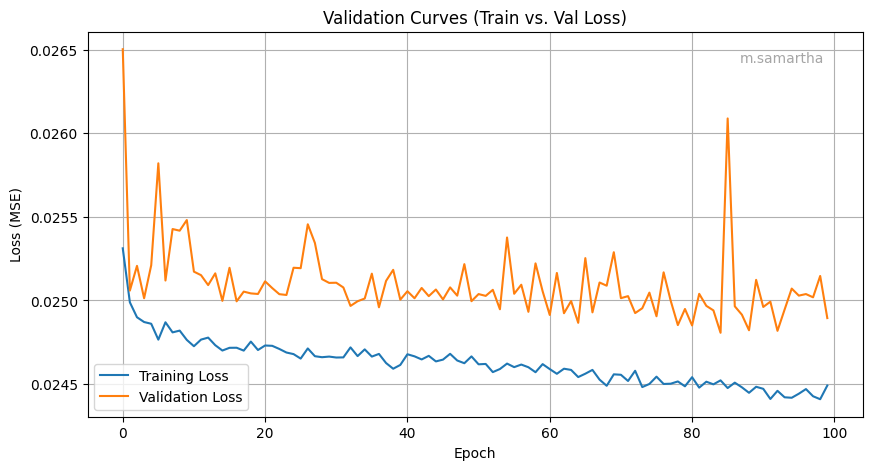

--- Validation Set Predictions ---


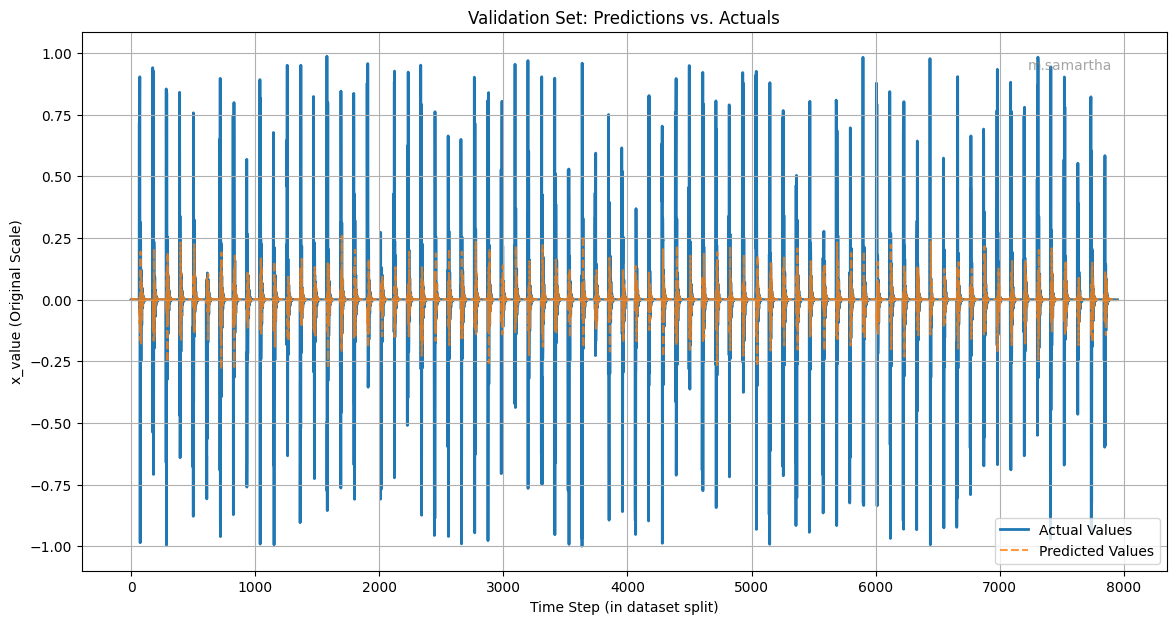

Mean Squared Error (on original scale) for Validation Set: Predictions vs. Actuals: 0.024934

--- Test Set Predictions ---


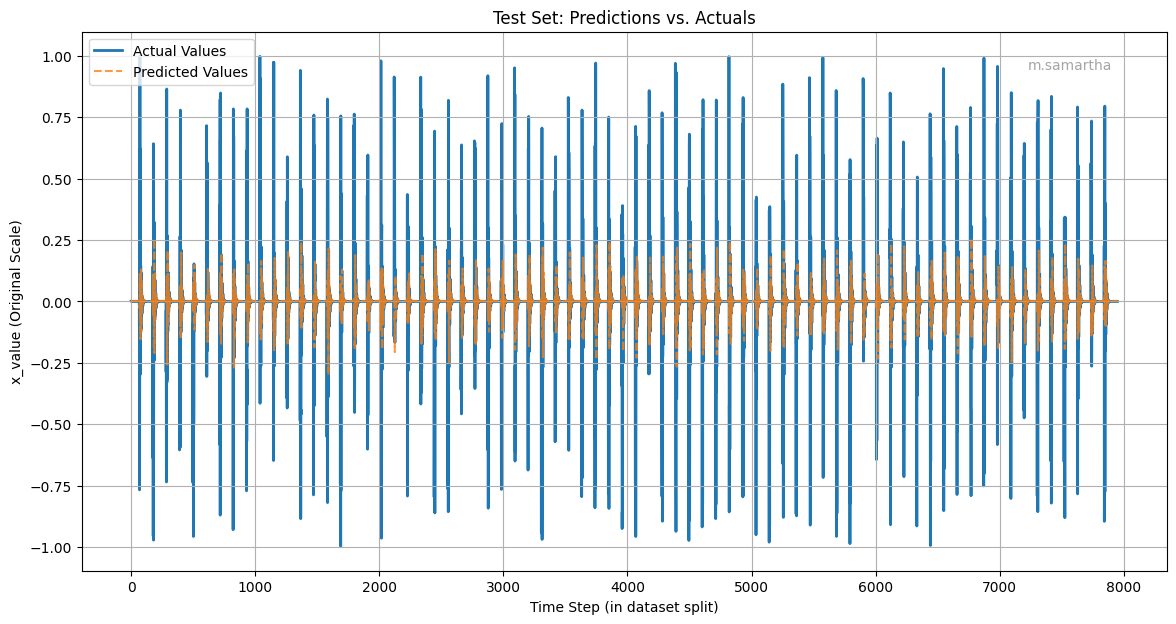

Mean Squared Error (on original scale) for Test Set: Predictions vs. Actuals: 0.023657



In [16]:
# 1. Plot the "Validation Curves"
plot_validation_curves(train_losses, val_losses)

# 2. Get predictions for all datasets
val_preds, val_actuals = get_predictions(model, val_loader, device)
test_preds, test_actuals = get_predictions(model, test_loader, device)

# 3. Plot the "Prediction Plots"
print("--- Validation Set Predictions ---")
plot_predictions(val_preds, val_actuals, processor, title='Validation Set: Predictions vs. Actuals')

print("--- Test Set Predictions ---")
plot_predictions(test_preds, test_actuals, processor, title='Test Set: Predictions vs. Actuals')

In [38]:
class RNNTimeSeriesTrainer:
    def __init__(self, 
                 file_path,
                 history_length_p,
                 input_size=1,
                 hidden_size=64,
                 num_layers=2,
                 output_size=1,
                 num_epochs=100,
                 learning_rate=0.001,
                 batch_size=32,
                 train_ratio=0.7,
                 val_ratio=0.15,
                 device=None):

        self.file_path = file_path
        self.history_length_p = history_length_p
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio

        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.train_losses = []
        self.val_losses = []

    # --------------------------------------------------
    # 1. Data Loading + Tensor Conversion + Dataloaders
    # --------------------------------------------------
    def prepare_data(self):
        # print(f"Using history length p = {self.history_length_p}")

        processor = TimeSeriesDataProcessor(
            filepath=self.file_path,
            p=self.history_length_p,
            train_ratio=self.train_ratio,
            val_ratio=self.val_ratio
        )

        X_train, y_train, X_val, y_val, X_test, y_test = processor.get_processed_data()

        # Convert to tensors
        X_train_t = torch.tensor(X_train).float().to(self.device)
        y_train_t = torch.tensor(y_train).float().view(-1, 1).to(self.device)

        X_val_t = torch.tensor(X_val).float().to(self.device)
        y_val_t = torch.tensor(y_val).float().view(-1, 1).to(self.device)

        X_test_t = torch.tensor(X_test).float().to(self.device)
        y_test_t = torch.tensor(y_test).float().view(-1, 1).to(self.device)

        # DataLoaders
        self.train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                                       batch_size=self.batch_size, shuffle=True)

        self.val_loader = DataLoader(TensorDataset(X_val_t, y_val_t),
                                     batch_size=self.batch_size, shuffle=False)

        self.test_loader = DataLoader(TensorDataset(X_test_t, y_test_t),
                                      batch_size=self.batch_size, shuffle=False)

        # print(f"DataLoaders created with batch size {self.batch_size}")

    # --------------------------------------------------
    # 2. Model/Optimizer Initialization
    # --------------------------------------------------
    def init_model(self):
        self.model = RNNModel(self.input_size,
                              self.hidden_size,
                              self.num_layers,
                              self.output_size).to(self.device)

        # print(self.model)

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    # --------------------------------------------------
    # 3. Training Loop (unchanged logic)
    # --------------------------------------------------
    def train(self):
        # print("Starting training...")
        start_time = time.time()

        for epoch in range(self.num_epochs):
            # ---- Training ----
            self.model.train()
            epoch_train_loss = 0

            for X_batch, y_batch in self.train_loader:
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_train_loss += loss.item()

            avg_train_loss = epoch_train_loss / len(self.train_loader)
            self.train_losses.append(avg_train_loss)

            # ---- Validation ----
            self.model.eval()
            epoch_val_loss = 0

            with torch.no_grad():
                for X_batch, y_batch in self.val_loader:
                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    epoch_val_loss += loss.item()

            avg_val_loss = epoch_val_loss / len(self.val_loader)
            self.val_losses.append(avg_val_loss)

            # Log every 10 epochs
            # if (epoch + 1) % 10 == 0 or epoch == 0:
                # print(f"Epoch [{epoch+1}/{self.num_epochs}], "
                #       f"Train Loss: {avg_train_loss:.6f}, "
                #       f"Val Loss: {avg_val_loss:.6f}")

        end_time = time.time()
        # print(f"Training finished in {end_time - start_time:.2f} seconds.")

    # --------------------------------------------------
    # 4. Return results in a neat DataFrame
    # --------------------------------------------------
    def get_results_df(self):
        df = pd.DataFrame({
            "epoch": range(1, self.num_epochs + 1),
            "train_loss": self.train_losses,
            "val_loss": self.val_losses
        })
        return df

    # --------------------------------------------------
    # Master function to run everything
    # --------------------------------------------------
    def run(self):
        self.prepare_data()
        self.init_model()
        self.train()

        return self.get_results_df()


In [28]:
trainer = RNNTimeSeriesTrainer(
    file_path='Dataset/Q2/recurrence_timeseries.csv',
    history_length_p=20,
    input_size=1,
    hidden_size=64,
    num_layers=2,
    output_size=1,
    num_epochs=100,
    learning_rate=0.001,
    batch_size=32
)

results_df = trainer.run()

Using history length p = 20
Data split:
  Raw total: 54000 points
  Train:     37800 points
  Validate:  8100 points
  Test:      8100 points

Final data shapes:
  X_train: (37780, 20, 1), y_train: (37780,)
  X_val:   (8080, 20, 1),   y_val:   (8080,)
  X_test:  (8080, 20, 1),  y_test:  (8080,)
DataLoaders created with batch size 32
RNNModel(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Starting training...
Epoch [1/100], Train Loss: 0.025265, Val Loss: 0.025870
Epoch [10/100], Train Loss: 0.024714, Val Loss: 0.025349
Epoch [20/100], Train Loss: 0.024680, Val Loss: 0.025114
Epoch [30/100], Train Loss: 0.024642, Val Loss: 0.025417
Epoch [40/100], Train Loss: 0.024637, Val Loss: 0.025127
Epoch [50/100], Train Loss: 0.024613, Val Loss: 0.025352
Epoch [60/100], Train Loss: 0.024588, Val Loss: 0.025337
Epoch [70/100], Train Loss: 0.024528, Val Loss: 0.025068
Epoch [80/100], Train Loss: 0.024491, Val Loss: 0.025002
Epoch [90/

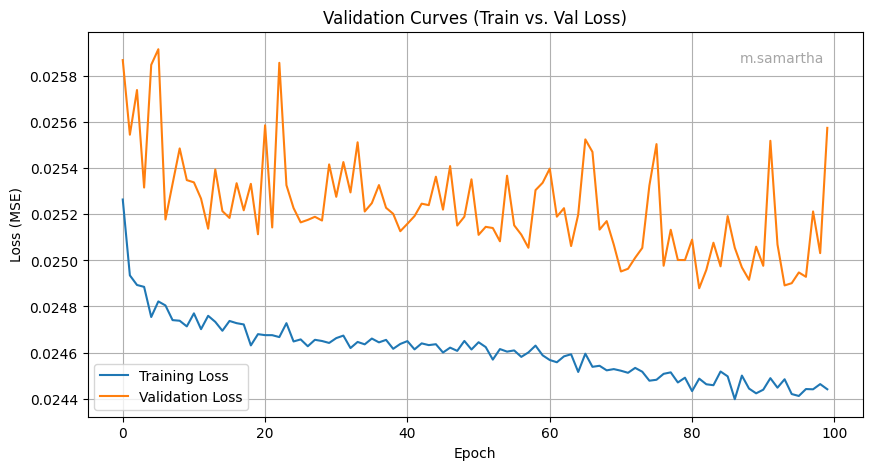

--- Validation Set Predictions ---


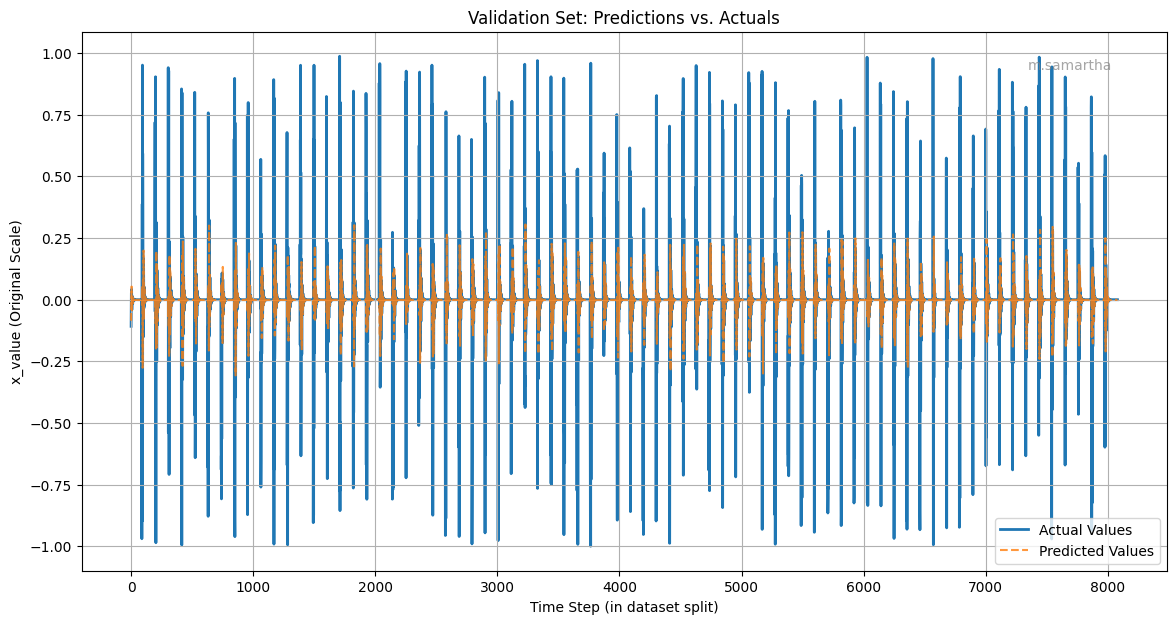

Mean Squared Error (on original scale) for Validation Set: Predictions vs. Actuals: 0.025176

--- Test Set Predictions ---


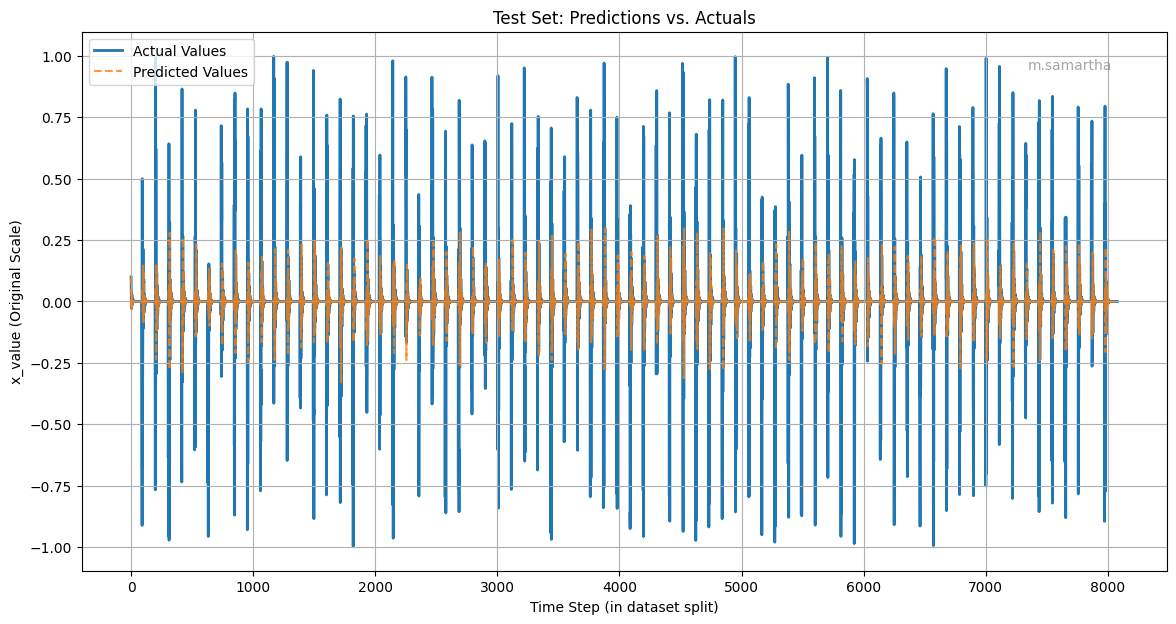

Mean Squared Error (on original scale) for Test Set: Predictions vs. Actuals: 0.023534



In [30]:
# 1. Plot the "Validation Curves"
train_losses = results_df['train_loss'].tolist()
val_losses = results_df['val_loss'].tolist()
plot_validation_curves(train_losses, val_losses)

# 2. Get predictions for all datasets
val_preds, val_actuals = get_predictions(model, val_loader, device)
test_preds, test_actuals = get_predictions(model, test_loader, device)

# 3. Plot the "Prediction Plots"
print("--- Validation Set Predictions ---")
plot_predictions(val_preds, val_actuals, processor, title='Validation Set: Predictions vs. Actuals')

print("--- Test Set Predictions ---")
plot_predictions(test_preds, test_actuals, processor, title='Test Set: Predictions vs. Actuals')

### Hyperparameter sweep

In [43]:
param_grid = {
    'history_length_p': [10, 20, 50, 100],
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.01, 0.001],
    'batch_size': [32, 64]
}

# --- FOR TESTING: A smaller, "coarse" grid ---
# param_grid = {
#     'history_length_p': [20, 40],
#     'hidden_size': [32, 64],
#     'num_layers': [1, 2],
#     'learning_rate': [0.001],
#     'batch_size': [32]
# }

# 1. Create a list of all parameter combinations
# Get the keys and values from the grid
param_keys = param_grid.keys()
param_values = param_grid.values()

# Create all combinations using itertools.product
# This creates a list of tuples: e.g., [(10, 32, 1, 0.01, 32), (10, 32, 1, 0.01, 64), ...]
combinations = list(itertools.product(*param_values))

print(f"Starting hyperparameter sweep with {len(combinations)} total combinations.")

# 2. List to store all results
all_results = []
start_time = time.time()

# 3. Iterate through all combinations with a progress bar
for i, combo in enumerate(tqdm(combinations, desc="Hyperparameter Trials"), start=1):
    
    # Create a dictionary of parameters for this trial
    params = dict(zip(param_keys, combo))
    
    # Add constant parameters
    params['file_path'] = 'Dataset/Q2/recurrence_timeseries.csv'
    params['input_size'] = 1
    params['output_size'] = 1
    params['num_epochs'] = 75 # You might want to use fewer epochs for a sweep
    
    # print(f"\n--- Running Trial: {params} ---")
    
    try:
        # 4. Instantiate and run the trainer
        trainer = RNNTimeSeriesTrainer(**params)
        results_df = trainer.run() # This returns the DataFrame
        
        # 5. Get the final validation loss for quick comparison
        final_val_loss = results_df['val_loss'].iloc[-1]
        # print(f"Trial complete. Final Val Loss: {final_val_loss:.6f}")
        
        # 6. Store the results
        all_results.append({
            'params': params,
            'results_df': results_df,
            'final_val_loss': final_val_loss
        })
        
    except Exception as e:
        # Catch errors (e.g., from bad hyperparameters) and continue
        print(f"!!! TRIAL FAILED for params {params} with error: {e} !!!")
        all_results.append({
            'params': params,
            'results_df': None, # Mark as failed
            'final_val_loss': float('inf') # Set infinite loss
        })
    print(f"Completed {i+1}/{len(combinations)}")

end_time = time.time()
print(f"\n--- Sweep Finished ---")
print(f"Total time taken: {(end_time - start_time) / 60:.2f} minutes")

Starting hyperparameter sweep with 144 total combinations.


Hyperparameter Trials:   1%|          | 1/144 [03:49<9:08:06, 229.98s/it]

Completed 2/144


Hyperparameter Trials:   1%|▏         | 2/144 [05:59<6:43:53, 170.66s/it]

Completed 3/144


Hyperparameter Trials:   2%|▏         | 3/144 [09:40<7:35:29, 193.83s/it]

Completed 4/144


Hyperparameter Trials:   3%|▎         | 4/144 [11:21<6:06:31, 157.08s/it]

Completed 5/144


Hyperparameter Trials:   3%|▎         | 5/144 [14:35<6:34:59, 170.50s/it]

Completed 6/144


Hyperparameter Trials:   4%|▍         | 6/144 [16:26<5:45:53, 150.39s/it]

Completed 7/144


Hyperparameter Trials:   5%|▍         | 7/144 [20:14<6:40:52, 175.57s/it]

Completed 8/144


Hyperparameter Trials:   6%|▌         | 8/144 [22:07<5:52:56, 155.71s/it]

Completed 9/144


Hyperparameter Trials:   6%|▋         | 9/144 [25:33<6:25:47, 171.47s/it]

Completed 10/144


Hyperparameter Trials:   7%|▋         | 10/144 [27:29<5:44:29, 154.25s/it]

Completed 11/144


Hyperparameter Trials:   8%|▊         | 11/144 [30:56<6:17:57, 170.51s/it]

Completed 12/144


Hyperparameter Trials:   8%|▊         | 12/144 [32:55<5:40:37, 154.83s/it]

Completed 13/144


Hyperparameter Trials:   9%|▉         | 13/144 [35:59<5:57:12, 163.61s/it]

Completed 14/144


Hyperparameter Trials:  10%|▉         | 14/144 [37:46<5:17:44, 146.65s/it]

Completed 15/144


Hyperparameter Trials:  10%|█         | 15/144 [40:48<5:38:11, 157.30s/it]

Completed 16/144


Hyperparameter Trials:  11%|█         | 16/144 [42:32<5:00:59, 141.09s/it]

Completed 17/144


Hyperparameter Trials:  12%|█▏        | 17/144 [45:51<5:35:36, 158.55s/it]

Completed 18/144


Hyperparameter Trials:  12%|█▎        | 18/144 [47:39<5:00:57, 143.31s/it]

Completed 19/144


Hyperparameter Trials:  13%|█▎        | 19/144 [50:57<5:33:01, 159.85s/it]

Completed 20/144


Hyperparameter Trials:  14%|█▍        | 20/144 [52:48<4:59:48, 145.07s/it]

Completed 21/144


Hyperparameter Trials:  15%|█▍        | 21/144 [56:16<5:36:09, 163.98s/it]

Completed 22/144


Hyperparameter Trials:  15%|█▌        | 22/144 [58:13<5:04:45, 149.88s/it]

Completed 23/144


Hyperparameter Trials:  16%|█▌        | 23/144 [1:01:42<5:38:16, 167.74s/it]

Completed 24/144


Hyperparameter Trials:  17%|█▋        | 24/144 [1:03:37<5:03:25, 151.72s/it]

Completed 25/144


Hyperparameter Trials:  17%|█▋        | 25/144 [1:06:46<5:23:06, 162.92s/it]

Completed 26/144


Hyperparameter Trials:  18%|█▊        | 26/144 [1:08:31<4:46:16, 145.57s/it]

Completed 27/144


Hyperparameter Trials:  19%|█▉        | 27/144 [1:11:38<5:08:29, 158.20s/it]

Completed 28/144


Hyperparameter Trials:  19%|█▉        | 28/144 [1:13:29<4:38:11, 143.90s/it]

Completed 29/144


Hyperparameter Trials:  20%|██        | 29/144 [1:16:57<5:12:51, 163.23s/it]

Completed 30/144


Hyperparameter Trials:  21%|██        | 30/144 [1:18:47<4:39:38, 147.18s/it]

Completed 31/144


Hyperparameter Trials:  22%|██▏       | 31/144 [1:22:10<5:08:28, 163.79s/it]

Completed 32/144


Hyperparameter Trials:  22%|██▏       | 32/144 [1:23:57<4:34:12, 146.90s/it]

Completed 33/144


Hyperparameter Trials:  23%|██▎       | 33/144 [1:27:37<5:12:14, 168.78s/it]

Completed 34/144


Hyperparameter Trials:  24%|██▎       | 34/144 [1:29:39<4:43:40, 154.73s/it]

Completed 35/144


Hyperparameter Trials:  24%|██▍       | 35/144 [1:33:18<5:15:57, 173.92s/it]

Completed 36/144


Hyperparameter Trials:  25%|██▌       | 36/144 [1:35:09<4:39:33, 155.31s/it]

Completed 37/144


Hyperparameter Trials:  26%|██▌       | 37/144 [1:38:07<4:49:05, 162.10s/it]

Completed 38/144


Hyperparameter Trials:  26%|██▋       | 38/144 [1:39:45<4:12:26, 142.89s/it]

Completed 39/144


Hyperparameter Trials:  27%|██▋       | 39/144 [1:42:42<4:27:28, 152.84s/it]

Completed 40/144


Hyperparameter Trials:  28%|██▊       | 40/144 [1:44:20<3:56:48, 136.62s/it]

Completed 41/144


Hyperparameter Trials:  28%|██▊       | 41/144 [1:47:32<4:22:56, 153.17s/it]

Completed 42/144


Hyperparameter Trials:  29%|██▉       | 42/144 [1:49:24<3:59:20, 140.79s/it]

Completed 43/144


Hyperparameter Trials:  30%|██▉       | 43/144 [1:52:33<4:21:23, 155.28s/it]

Completed 44/144


Hyperparameter Trials:  31%|███       | 44/144 [1:54:20<3:54:44, 140.85s/it]

Completed 45/144


Hyperparameter Trials:  31%|███▏      | 45/144 [1:57:49<4:25:56, 161.18s/it]

Completed 46/144


Hyperparameter Trials:  32%|███▏      | 46/144 [1:59:44<4:00:39, 147.35s/it]

Completed 47/144


Hyperparameter Trials:  33%|███▎      | 47/144 [2:03:09<4:26:20, 164.75s/it]

Completed 48/144


Hyperparameter Trials:  33%|███▎      | 48/144 [2:05:08<4:01:33, 150.98s/it]

Completed 49/144


Hyperparameter Trials:  34%|███▍      | 49/144 [2:08:05<4:11:23, 158.77s/it]

Completed 50/144


Hyperparameter Trials:  35%|███▍      | 50/144 [2:09:51<3:44:01, 142.99s/it]

Completed 51/144


Hyperparameter Trials:  35%|███▌      | 51/144 [2:12:50<3:58:09, 153.65s/it]

Completed 52/144


Hyperparameter Trials:  36%|███▌      | 52/144 [2:14:32<3:32:02, 138.28s/it]

Completed 53/144


Hyperparameter Trials:  37%|███▋      | 53/144 [2:17:50<3:56:58, 156.25s/it]

Completed 54/144


Hyperparameter Trials:  38%|███▊      | 54/144 [2:19:37<3:31:52, 141.25s/it]

Completed 55/144


Hyperparameter Trials:  38%|███▊      | 55/144 [2:22:54<3:54:33, 158.13s/it]

Completed 56/144


Hyperparameter Trials:  39%|███▉      | 56/144 [2:24:43<3:30:09, 143.29s/it]

Completed 57/144


Hyperparameter Trials:  40%|███▉      | 57/144 [2:28:10<3:55:45, 162.60s/it]

Completed 58/144


Hyperparameter Trials:  40%|████      | 58/144 [2:30:13<3:35:55, 150.64s/it]

Completed 59/144


Hyperparameter Trials:  41%|████      | 59/144 [2:33:47<4:00:13, 169.57s/it]

Completed 60/144


Hyperparameter Trials:  42%|████▏     | 60/144 [2:35:43<3:35:05, 153.63s/it]

Completed 61/144


Hyperparameter Trials:  42%|████▏     | 61/144 [2:38:59<3:50:08, 166.37s/it]

Completed 62/144


Hyperparameter Trials:  43%|████▎     | 62/144 [2:40:46<3:22:42, 148.32s/it]

Completed 63/144


Hyperparameter Trials:  44%|████▍     | 63/144 [2:43:47<3:33:27, 158.11s/it]

Completed 64/144


Hyperparameter Trials:  44%|████▍     | 64/144 [2:45:32<3:09:47, 142.34s/it]

Completed 65/144


Hyperparameter Trials:  45%|████▌     | 65/144 [2:48:54<3:30:50, 160.13s/it]

Completed 66/144


Hyperparameter Trials:  46%|████▌     | 66/144 [2:50:44<3:08:38, 145.11s/it]

Completed 67/144


Hyperparameter Trials:  47%|████▋     | 67/144 [2:54:08<3:28:50, 162.74s/it]

Completed 68/144


Hyperparameter Trials:  47%|████▋     | 68/144 [2:55:56<3:05:30, 146.46s/it]

Completed 69/144


Hyperparameter Trials:  48%|████▊     | 69/144 [2:59:35<3:30:18, 168.25s/it]

Completed 70/144


Hyperparameter Trials:  49%|████▊     | 70/144 [3:01:38<3:10:31, 154.49s/it]

Completed 71/144


Hyperparameter Trials:  49%|████▉     | 71/144 [3:05:27<3:35:09, 176.84s/it]

Completed 72/144


Hyperparameter Trials:  50%|█████     | 72/144 [3:07:21<3:09:47, 158.16s/it]

Completed 73/144


Hyperparameter Trials:  51%|█████     | 73/144 [3:10:29<3:17:39, 167.04s/it]

Completed 74/144


Hyperparameter Trials:  51%|█████▏    | 74/144 [3:12:09<2:51:33, 147.05s/it]

Completed 75/144


Hyperparameter Trials:  52%|█████▏    | 75/144 [3:15:15<3:02:17, 158.51s/it]

Completed 76/144


Hyperparameter Trials:  53%|█████▎    | 76/144 [3:16:58<2:40:43, 141.81s/it]

Completed 77/144


Hyperparameter Trials:  53%|█████▎    | 77/144 [3:20:09<2:55:06, 156.82s/it]

Completed 78/144


Hyperparameter Trials:  54%|█████▍    | 78/144 [3:22:04<2:38:29, 144.08s/it]

Completed 79/144


Hyperparameter Trials:  55%|█████▍    | 79/144 [3:25:22<2:53:44, 160.38s/it]

Completed 80/144


Hyperparameter Trials:  56%|█████▌    | 80/144 [3:27:07<2:33:25, 143.83s/it]

Completed 81/144


Hyperparameter Trials:  56%|█████▋    | 81/144 [3:30:38<2:52:01, 163.84s/it]

Completed 82/144


Hyperparameter Trials:  57%|█████▋    | 82/144 [3:32:32<2:33:50, 148.88s/it]

Completed 83/144


Hyperparameter Trials:  58%|█████▊    | 83/144 [3:35:59<2:49:15, 166.48s/it]

Completed 84/144


Hyperparameter Trials:  58%|█████▊    | 84/144 [3:38:00<2:32:40, 152.68s/it]

Completed 85/144


Hyperparameter Trials:  59%|█████▉    | 85/144 [3:41:01<2:38:39, 161.35s/it]

Completed 86/144


Hyperparameter Trials:  60%|█████▉    | 86/144 [3:42:41<2:18:03, 142.82s/it]

Completed 87/144


Hyperparameter Trials:  60%|██████    | 87/144 [3:45:42<2:26:33, 154.27s/it]

Completed 88/144


Hyperparameter Trials:  61%|██████    | 88/144 [3:47:21<2:08:22, 137.54s/it]

Completed 89/144


Hyperparameter Trials:  62%|██████▏   | 89/144 [3:50:40<2:23:12, 156.23s/it]

Completed 90/144


Hyperparameter Trials:  62%|██████▎   | 90/144 [3:52:31<2:08:16, 142.52s/it]

Completed 91/144


Hyperparameter Trials:  63%|██████▎   | 91/144 [3:55:51<2:21:11, 159.85s/it]

Completed 92/144


Hyperparameter Trials:  64%|██████▍   | 92/144 [3:57:46<2:06:47, 146.30s/it]

Completed 93/144


Hyperparameter Trials:  65%|██████▍   | 93/144 [4:01:23<2:22:32, 167.69s/it]

Completed 94/144


Hyperparameter Trials:  65%|██████▌   | 94/144 [4:03:16<2:06:03, 151.27s/it]

Completed 95/144


Hyperparameter Trials:  66%|██████▌   | 95/144 [4:06:49<2:18:28, 169.55s/it]

Completed 96/144


Hyperparameter Trials:  67%|██████▋   | 96/144 [4:08:46<2:03:07, 153.91s/it]

Completed 97/144


Hyperparameter Trials:  67%|██████▋   | 97/144 [4:11:48<2:07:03, 162.20s/it]

Completed 98/144


Hyperparameter Trials:  68%|██████▊   | 98/144 [4:13:37<1:52:08, 146.27s/it]

Completed 99/144


Hyperparameter Trials:  69%|██████▉   | 99/144 [4:16:39<1:57:51, 157.14s/it]

Completed 100/144


Hyperparameter Trials:  69%|██████▉   | 100/144 [4:18:26<1:44:10, 142.06s/it]

Completed 101/144


Hyperparameter Trials:  70%|███████   | 101/144 [4:21:51<1:55:23, 161.02s/it]

Completed 102/144


Hyperparameter Trials:  71%|███████   | 102/144 [4:23:41<1:42:01, 145.74s/it]

Completed 103/144


Hyperparameter Trials:  72%|███████▏  | 103/144 [4:27:05<1:51:27, 163.11s/it]

Completed 104/144


Hyperparameter Trials:  72%|███████▏  | 104/144 [4:28:59<1:38:58, 148.46s/it]

Completed 105/144


Hyperparameter Trials:  73%|███████▎  | 105/144 [4:32:33<1:49:18, 168.16s/it]

Completed 106/144


Hyperparameter Trials:  74%|███████▎  | 106/144 [4:34:34<1:37:26, 153.84s/it]

Completed 107/144


Hyperparameter Trials:  74%|███████▍  | 107/144 [4:38:12<1:46:46, 173.16s/it]

Completed 108/144


Hyperparameter Trials:  75%|███████▌  | 108/144 [4:40:09<1:33:45, 156.28s/it]

Completed 109/144


Hyperparameter Trials:  76%|███████▌  | 109/144 [4:43:15<1:36:17, 165.06s/it]

Completed 110/144


Hyperparameter Trials:  76%|███████▋  | 110/144 [4:44:58<1:23:00, 146.49s/it]

Completed 111/144


Hyperparameter Trials:  77%|███████▋  | 111/144 [4:47:54<1:25:31, 155.51s/it]

Completed 112/144


Hyperparameter Trials:  78%|███████▊  | 112/144 [4:49:40<1:14:55, 140.49s/it]

Completed 113/144


Hyperparameter Trials:  78%|███████▊  | 113/144 [4:52:57<1:21:26, 157.63s/it]

Completed 114/144


Hyperparameter Trials:  79%|███████▉  | 114/144 [4:54:44<1:11:12, 142.41s/it]

Completed 115/144


Hyperparameter Trials:  80%|███████▉  | 115/144 [4:58:06<1:17:24, 160.14s/it]

Completed 116/144


Hyperparameter Trials:  81%|████████  | 116/144 [4:59:53<1:07:18, 144.24s/it]

Completed 117/144


Hyperparameter Trials:  81%|████████▏ | 117/144 [5:03:29<1:14:34, 165.73s/it]

Completed 118/144


Hyperparameter Trials:  82%|████████▏ | 118/144 [5:05:31<1:06:09, 152.67s/it]

Completed 119/144


Hyperparameter Trials:  83%|████████▎ | 119/144 [5:09:04<1:11:06, 170.67s/it]

Completed 120/144


Hyperparameter Trials:  83%|████████▎ | 120/144 [5:10:59<1:01:36, 154.02s/it]

Completed 121/144


Hyperparameter Trials:  84%|████████▍ | 121/144 [5:14:05<1:02:44, 163.69s/it]

Completed 122/144


Hyperparameter Trials:  85%|████████▍ | 122/144 [5:15:47<53:12, 145.10s/it]  

Completed 123/144


Hyperparameter Trials:  85%|████████▌ | 123/144 [5:18:57<55:31, 158.63s/it]

Completed 124/144


Hyperparameter Trials:  86%|████████▌ | 124/144 [5:20:42<47:29, 142.49s/it]

Completed 125/144


Hyperparameter Trials:  87%|████████▋ | 125/144 [5:23:56<50:03, 158.07s/it]

Completed 126/144


Hyperparameter Trials:  88%|████████▊ | 126/144 [5:25:51<43:32, 145.12s/it]

Completed 127/144


Hyperparameter Trials:  88%|████████▊ | 127/144 [5:29:10<45:41, 161.24s/it]

Completed 128/144


Hyperparameter Trials:  89%|████████▉ | 128/144 [5:30:58<38:43, 145.23s/it]

Completed 129/144


Hyperparameter Trials:  90%|████████▉ | 129/144 [5:34:34<41:39, 166.65s/it]

Completed 130/144


Hyperparameter Trials:  90%|█████████ | 130/144 [5:36:31<35:23, 151.68s/it]

Completed 131/144


Hyperparameter Trials:  91%|█████████ | 131/144 [5:40:02<36:42, 169.39s/it]

Completed 132/144


Hyperparameter Trials:  92%|█████████▏| 132/144 [5:42:02<30:55, 154.64s/it]

Completed 133/144


Hyperparameter Trials:  92%|█████████▏| 133/144 [5:45:09<30:07, 164.34s/it]

Completed 134/144


Hyperparameter Trials:  93%|█████████▎| 134/144 [5:46:54<24:24, 146.42s/it]

Completed 135/144


Hyperparameter Trials:  94%|█████████▍| 135/144 [5:50:02<23:51, 159.03s/it]

Completed 136/144


Hyperparameter Trials:  94%|█████████▍| 136/144 [5:51:40<18:44, 140.57s/it]

Completed 137/144


Hyperparameter Trials:  95%|█████████▌| 137/144 [5:54:59<18:28, 158.29s/it]

Completed 138/144


Hyperparameter Trials:  96%|█████████▌| 138/144 [5:56:54<14:31, 145.27s/it]

Completed 139/144


Hyperparameter Trials:  97%|█████████▋| 139/144 [6:00:18<13:34, 162.80s/it]

Completed 140/144


Hyperparameter Trials:  97%|█████████▋| 140/144 [6:02:16<09:57, 149.47s/it]

Completed 141/144


Hyperparameter Trials:  98%|█████████▊| 141/144 [6:06:02<08:36, 172.25s/it]

Completed 142/144


Hyperparameter Trials:  99%|█████████▊| 142/144 [6:08:04<05:14, 157.28s/it]

Completed 143/144


Hyperparameter Trials:  99%|█████████▉| 143/144 [6:11:45<02:56, 176.26s/it]

Completed 144/144


Hyperparameter Trials: 100%|██████████| 144/144 [6:13:56<00:00, 155.81s/it]

Completed 145/144

--- Sweep Finished ---
Total time taken: 373.94 minutes


In [44]:
# --- D. SAVING THE RESULTS OBJECT ---

# Save the entire 'all_results' list to a file using pickle
results_filename = 'rnn_hyperparameter_sweep.pkl'
with open(results_filename, 'wb') as f:
    pickle.dump(all_results, f)

print(f"\nSuccessfully saved all results to '{results_filename}'")


Successfully saved all results to 'rnn_hyperparameter_sweep.pkl'


In [56]:
# 1. Load the results object from the file
results_filename = 'Results/Q2/rnn_hyperparameter_sweep.pkl'
with open(results_filename, 'rb') as f:
    all_results = pickle.load(f)

print(f"Loaded {len(all_results)} trial results.")

# 2. Create a "master" DataFrame for easy analysis
# This is great for finding the best parameters
analysis_data = []
for res in all_results:
    # Flatten the 'params' dict and add the final loss
    row = res['params'].copy()
    row['final_val_loss'] = res['final_val_loss']
    analysis_data.append(row)

analysis_df = pd.DataFrame(analysis_data)
analysis_df.drop(columns=['file_path', 'input_size', 'output_size', 'num_epochs'], inplace=True)
# 3. Sort by the best validation loss to find the winner
analysis_df = analysis_df.sort_values(by='final_val_loss', ascending=True)

print("\n--- Top 5 Best Performing Models ---")
print(analysis_df.head())

# 4. Get the *best* model's details
best_trial = all_results[analysis_df.index[0]]
best_params = best_trial['params']
best_loss_curve_df = best_trial['results_df']

print(f"\n--- Best Model Parameters ---")
print(best_params)


Loaded 144 trial results.

--- Top 5 Best Performing Models ---
    history_length_p  hidden_size  num_layers  learning_rate  batch_size  \
7                 10           32           2          0.001          64   
59                20           64           3          0.001          64   
47                20           32           3          0.001          64   
19                10           64           2          0.001          64   
55                20           64           2          0.001          64   

    final_val_loss  
7         0.024860  
59        0.024956  
47        0.024967  
19        0.024976  
55        0.025011  

--- Best Model Parameters ---
{'history_length_p': 10, 'hidden_size': 32, 'num_layers': 2, 'learning_rate': 0.001, 'batch_size': 64, 'file_path': 'Dataset/Q2/recurrence_timeseries.csv', 'input_size': 1, 'output_size': 1, 'num_epochs': 75}


In [11]:
# Show the structure of all_results
print(f"Total number of trials: {len(all_results)}")
print(f"\nStructure of first result:")
print(f"Keys: {all_results[0].keys()}")
print(f"\nSample result:")
print(f"  Params: {all_results[0]['params']}")
print(f"  Final Val Loss: {all_results[0]['final_val_loss']}")
print(f"  Results DF shape: {all_results[0]['results_df'].shape if all_results[0]['results_df'] is not None else 'None'}")

Total number of trials: 144

Structure of first result:
Keys: dict_keys(['params', 'results_df', 'final_val_loss'])

Sample result:
  Params: {'history_length_p': 10, 'hidden_size': 32, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 32, 'file_path': 'Dataset/Q2/recurrence_timeseries.csv', 'input_size': 1, 'output_size': 1, 'num_epochs': 75}
  Final Val Loss: 0.02984864458813527
  Results DF shape: (75, 3)


### Best model analysis

In [47]:
best_model = RNNTimeSeriesTrainer(
    file_path='Dataset/Q2/recurrence_timeseries.csv',
    history_length_p=10,
    input_size=1,
    hidden_size=32,
    num_layers=2,
    output_size=1,
    num_epochs=100,
    learning_rate=0.001,
    batch_size=64
)

best_model_df = best_model.run()

In [48]:
# Save the trained model for future use
model_save_path = 'best_rnn_model.pth'
torch.save(best_model.model.state_dict(), model_save_path)

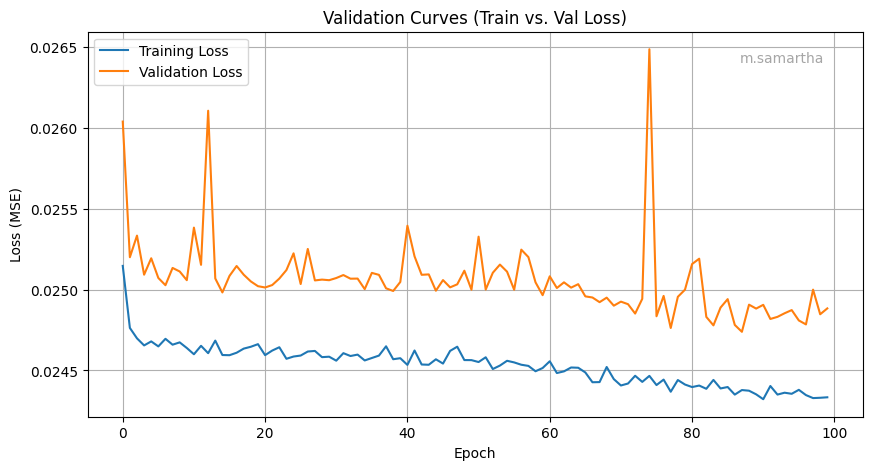

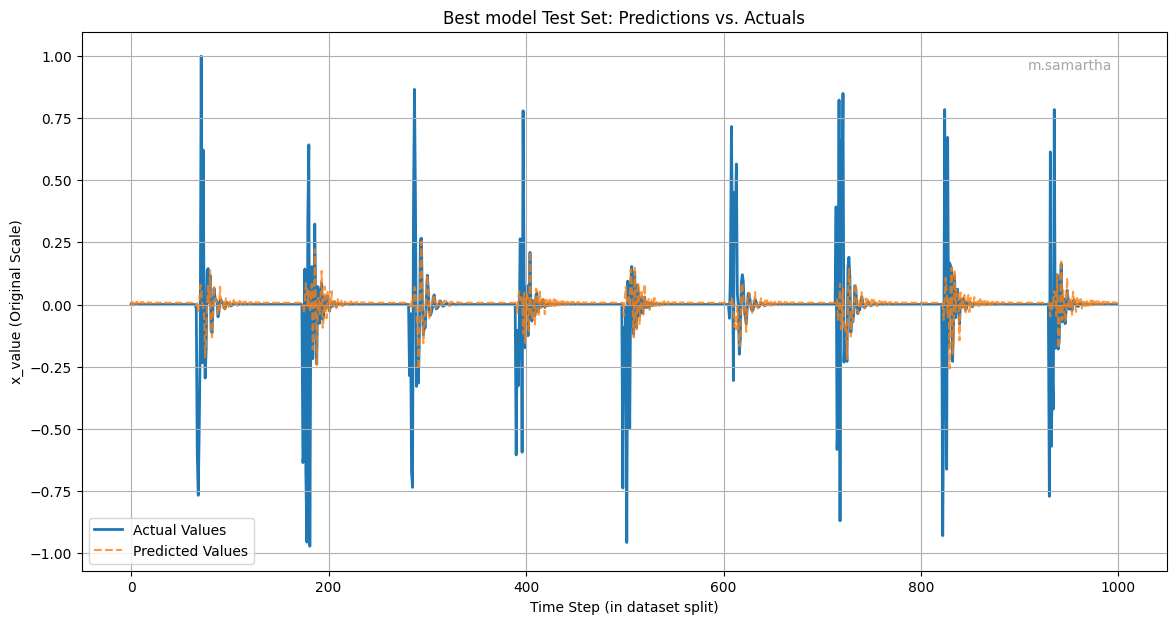

Mean Squared Error (on original scale) for Best model Test Set: Predictions vs. Actuals: 0.023645



In [49]:
# Plot the best model's validation curve

# 1. Plot the "Validation Curves"
train_losses = best_model_df['train_loss'].tolist()
val_losses = best_model_df['val_loss'].tolist()
plot_validation_curves(train_losses, val_losses)

# 2. Get predictions for test datasets
test_preds, test_actuals = get_predictions(best_model.model, test_loader, device)

plot_predictions(test_preds, test_actuals, processor, title='Best model Test Set: Predictions vs. Actuals', low = 0, high = 1000)

### Hyperparameter visualizations

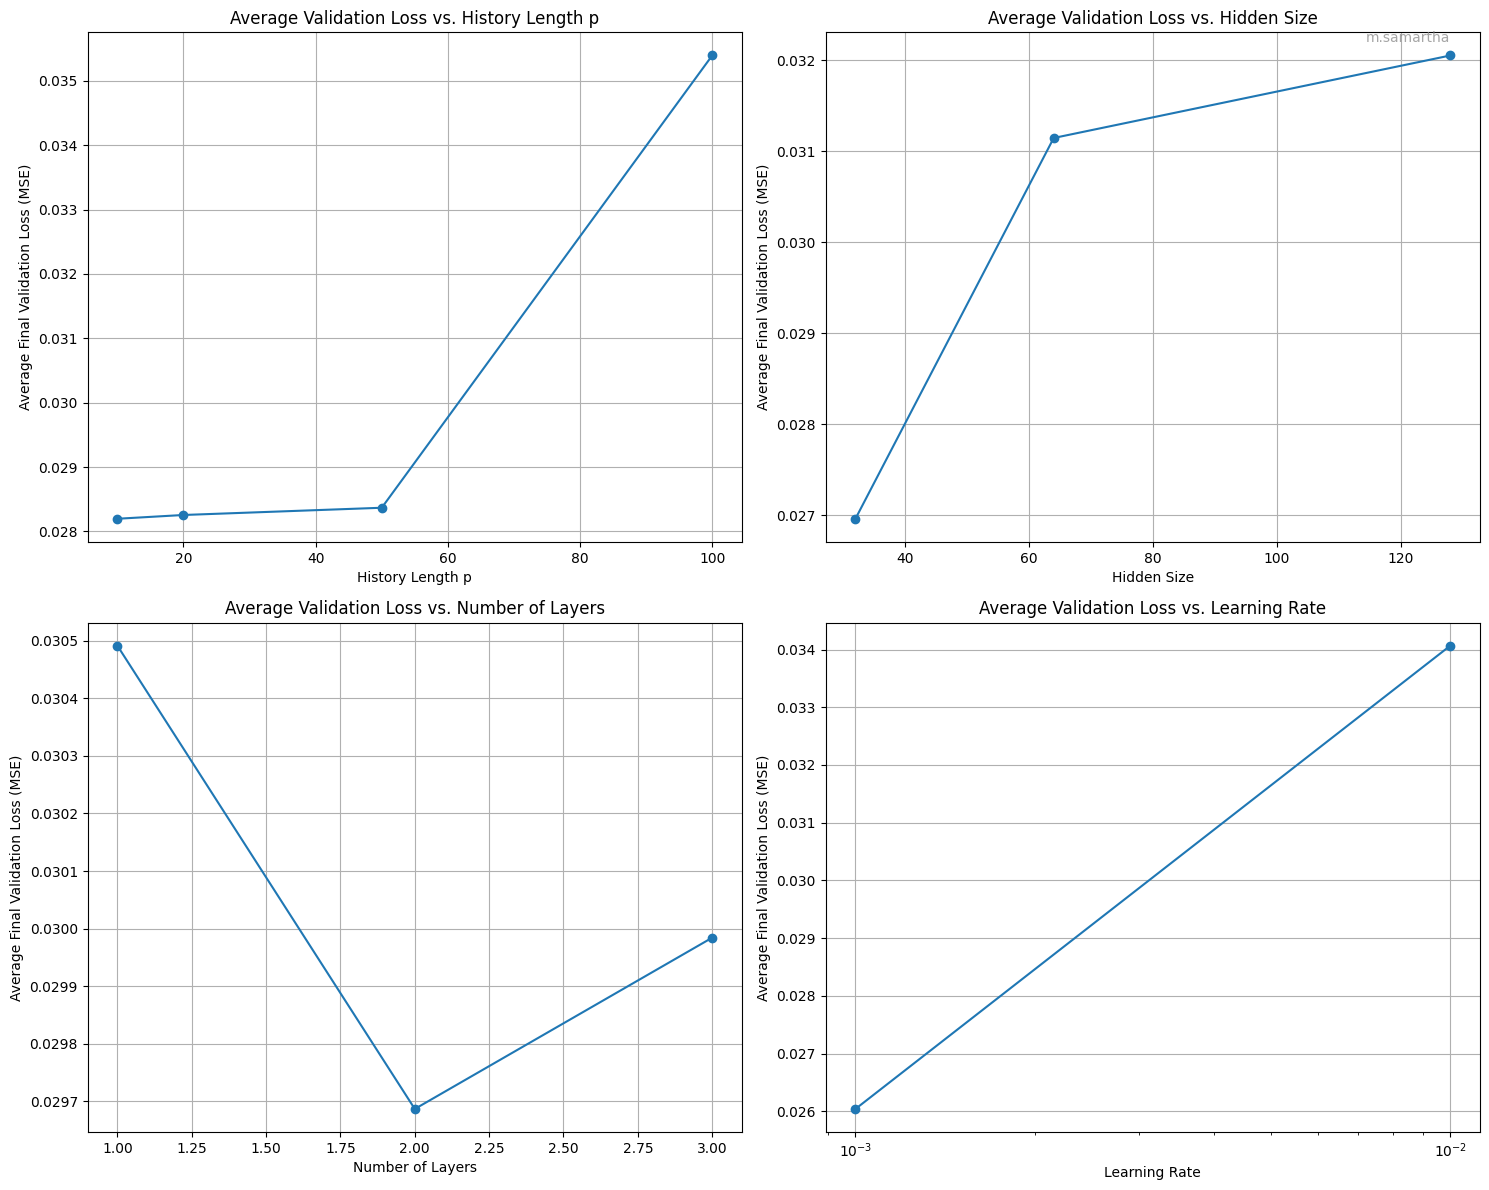

In [ ]:
# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: losses vs history length p
p_values = sorted(analysis_df['history_length_p'].unique())
avg_val_losses = []
for p in p_values:
    subset = analysis_df[analysis_df['history_length_p'] == p]
    avg_loss = subset['final_val_loss'].mean()
    avg_val_losses.append(avg_loss)
axes[0, 0].plot(p_values, avg_val_losses, marker='o')
axes[0, 0].set_title('Average Validation Loss vs. History Length p')
axes[0, 0].set_xlabel('History Length p')
axes[0, 0].set_ylabel('Average Final Validation Loss (MSE)')
axes[0, 0].grid(True)

# Plot 2: losses vs hidden size
hidden_sizes = sorted(analysis_df['hidden_size'].unique())
avg_val_losses = []
for hs in hidden_sizes:
    subset = analysis_df[analysis_df['hidden_size'] == hs]
    avg_loss = subset['final_val_loss'].mean()
    avg_val_losses.append(avg_loss)
axes[0, 1].plot(hidden_sizes, avg_val_losses, marker='o')
axes[0, 1].set_title('Average Validation Loss vs. Hidden Size')    
axes[0, 1].set_xlabel('Hidden Size')
axes[0, 1].set_ylabel('Average Final Validation Loss (MSE)')
axes[0, 1].grid(True)

# Plot 3: losses vs number of layers
num_layers_list = sorted(analysis_df['num_layers'].unique())
avg_val_losses = [] 
for nl in num_layers_list:
    subset = analysis_df[analysis_df['num_layers'] == nl]
    avg_loss = subset['final_val_loss'].mean()
    avg_val_losses.append(avg_loss)
axes[1, 0].plot(num_layers_list, avg_val_losses, marker='o')
axes[1, 0].set_title('Average Validation Loss vs. Number of Layers')    
axes[1, 0].set_xlabel('Number of Layers')
axes[1, 0].set_ylabel('Average Final Validation Loss (MSE)')
axes[1, 0].grid(True)

# Plot 4: losses vs learning rate
learning_rates = sorted(analysis_df['learning_rate'].unique())
avg_val_losses = []
for lr in learning_rates:
    subset = analysis_df[analysis_df['learning_rate'] == lr]
    avg_loss = subset['final_val_loss'].mean()
    avg_val_losses.append(avg_loss)
axes[1, 1].plot(learning_rates, avg_val_losses, marker='o')
axes[1, 1].set_xscale('log')
axes[1, 1].set_title('Average Validation Loss vs. Learning Rate')    
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('Average Final Validation Loss (MSE)')
axes[1, 1].grid(True)

plt.tight_layout()
add_username_fig(fig=fig)
plt.show()

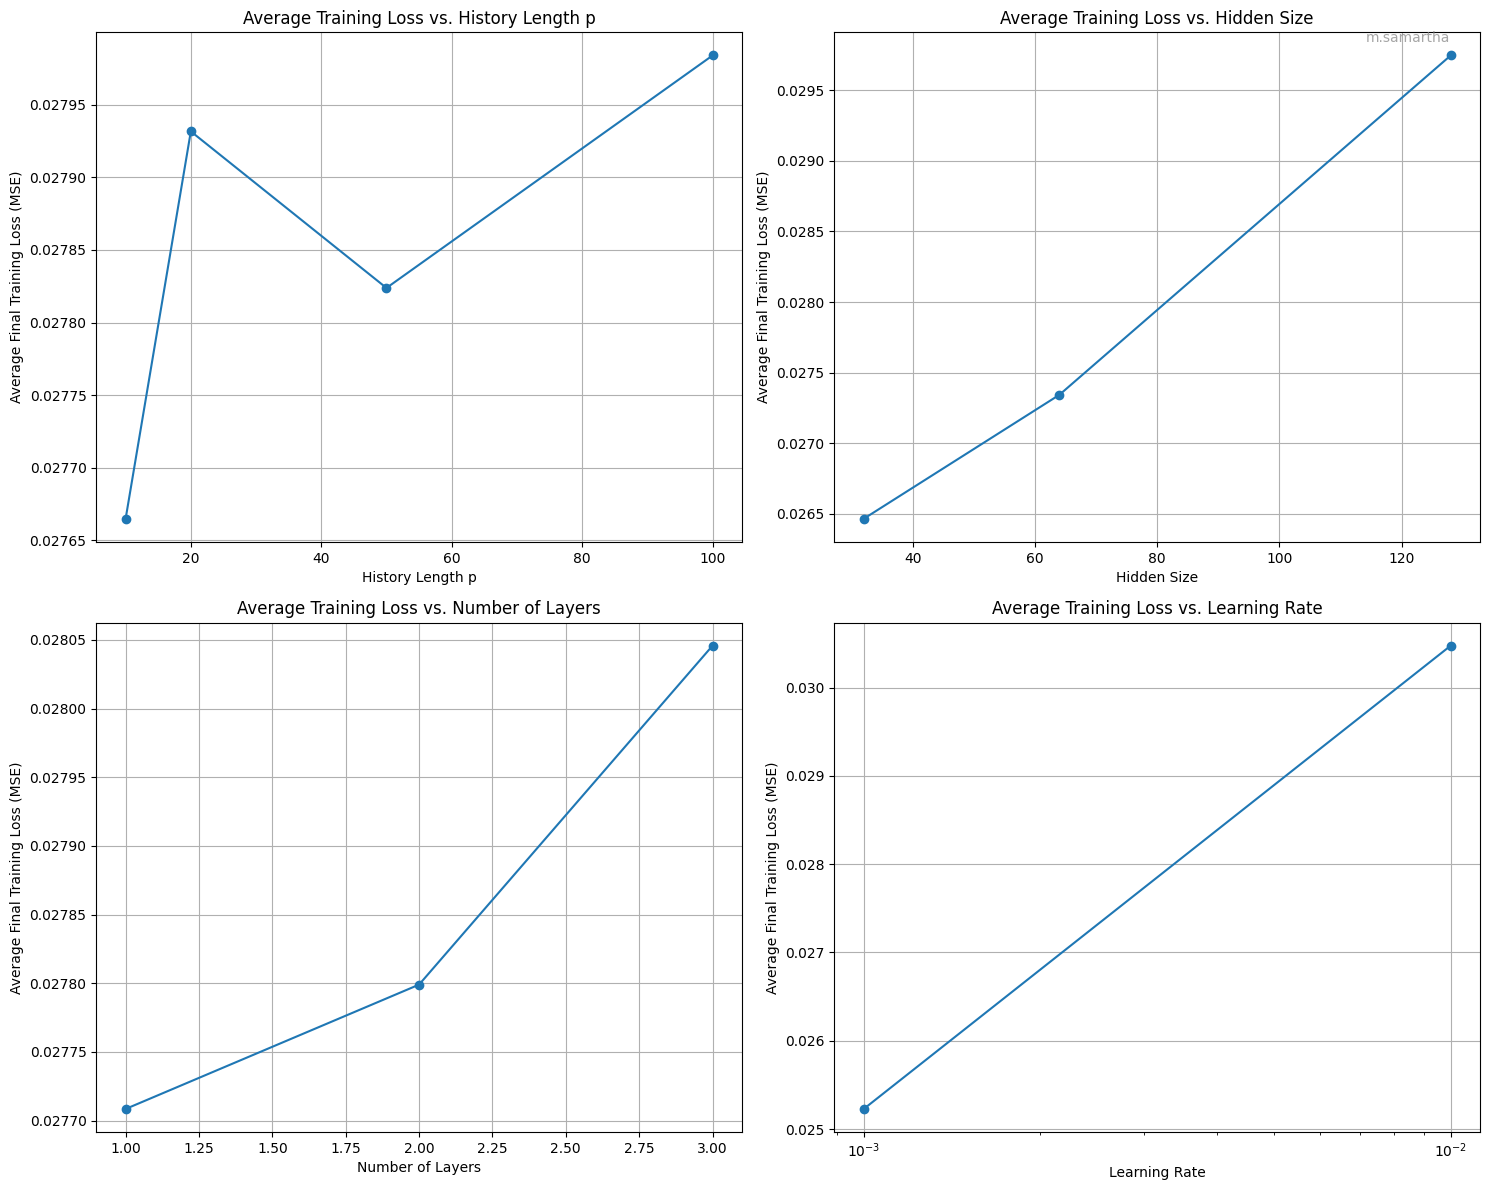

In [ ]:
# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: losses vs history length p
p_values = sorted(analysis_df['history_length_p'].unique())
avg_train_losses = []
for p in p_values:
    subset_indices = analysis_df[analysis_df['history_length_p'] == p].index
    avg_loss = np.mean([all_results[idx]['results_df']['train_loss'].iloc[-1] for idx in subset_indices])
    avg_train_losses.append(avg_loss)
axes[0, 0].plot(p_values, avg_train_losses, marker='o')
axes[0, 0].set_title('Average Training Loss vs. History Length p')
axes[0, 0].set_xlabel('History Length p')
axes[0, 0].set_ylabel('Average Final Training Loss (MSE)')
axes[0, 0].grid(True)

# Plot 2: losses vs hidden size
hidden_sizes = sorted(analysis_df['hidden_size'].unique())
avg_train_losses = []
for hs in hidden_sizes:
    subset_indices = analysis_df[analysis_df['hidden_size'] == hs].index
    avg_loss = np.mean([all_results[idx]['results_df']['train_loss'].iloc[-1] for idx in subset_indices])
    avg_train_losses.append(avg_loss)
axes[0, 1].plot(hidden_sizes, avg_train_losses, marker='o')
axes[0, 1].set_title('Average Training Loss vs. Hidden Size')    
axes[0, 1].set_xlabel('Hidden Size')
axes[0, 1].set_ylabel('Average Final Training Loss (MSE)')
axes[0, 1].grid(True)

# Plot 3: losses vs number of layers
num_layers_list = sorted(analysis_df['num_layers'].unique())
avg_train_losses = [] 
for nl in num_layers_list:
    subset_indices = analysis_df[analysis_df['num_layers'] == nl].index
    avg_loss = np.mean([all_results[idx]['results_df']['train_loss'].iloc[-1] for idx in subset_indices])
    avg_train_losses.append(avg_loss)
axes[1, 0].plot(num_layers_list, avg_train_losses, marker='o')
axes[1, 0].set_title('Average Training Loss vs. Number of Layers')    
axes[1, 0].set_xlabel('Number of Layers')
axes[1, 0].set_ylabel('Average Final Training Loss (MSE)')
axes[1, 0].grid(True)

# Plot 4: losses vs learning rate
learning_rates = sorted(analysis_df['learning_rate'].unique())
avg_train_losses = []
for lr in learning_rates:
    subset_indices = analysis_df[analysis_df['learning_rate'] == lr].index
    avg_loss = np.mean([all_results[idx]['results_df']['train_loss'].iloc[-1] for idx in subset_indices])
    avg_train_losses.append(avg_loss)
axes[1, 1].plot(learning_rates, avg_train_losses, marker='o')
axes[1, 1].set_xscale('log')
axes[1, 1].set_title('Average Training Loss vs. Learning Rate')    
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('Average Final Training Loss (MSE)')
axes[1, 1].grid(True)

plt.tight_layout()
add_username_fig(fig=fig)
plt.show()

## Analysis of Hyperparameter Trends

Our hyperparameter sweep revealed a counter-intuitive but consistent trend: **simpler models generally outperformed complex ones**. Specifically, both training and validation losses increased (worsened) as we increased the history length ($p$), hidden size, and number of layers.

While deep learning intuition often suggests *“more capacity = better performance,”* our results indicate the opposite. We attribute this behavior to three primary factors: **Vanishing Gradients**, **Over-parameterization relative to intrinsic dimension**, and **Optimization Difficulties**.

---

### 1. Impact of History Length $p$

The observation that loss increases with `history_length_p` strongly suggests that the underlying mechanism generating the data is **Markovian with a low order**. This can also be reasoned by the PACF plot showing significant correlations only up to lag 8.

If the true value $x_k$ depends only on the immediate past (e.g., $x_{k-1}, x_{k-2}$), then providing a history of $p=50$ forces the RNN to process **48 steps of irrelevant noise**. This noise worsens the learning and generalization.

#### Gradient Dilution  
With a standard RNN, backpropagating errors through 50 time steps is much harder than through 10.  
The gradient signal for the relevant recent inputs becomes **diluted** or corrupted by irrelevant distant inputs.

---

### 2. Optimization Challenges: The Vanishing Gradient Problem (Impact of Layers)

The degradation in performance with increased `num_layers` is a an indication of the **Vanishing Gradient Problem**, which is severe in standard Elman RNNs (unlike LSTMs/GRUs). 
In a multi-layer RNN, the error signal must propagate **back through time** (BPTT) and **down through layers**.  
As layers are added, the gradient path grows exponentially longer.

---

### 3. Over-parameterization & Fixed Hyperparameters (Impact of Hidden Size)

The increase in loss with larger `hidden_size` supports the view that **large models are harder to optimize**, especially with a fixed learning rate and epoch count.

#### Loss Surface Geometry  
Larger models (e.g., 128 units) produce a **high-dimensional, rugged error surface** with many saddle points.  
A learning rate tuned for a small model becomes either:

- too aggressive → oscillation / divergence  
- too small → stuck in plateaus  

Bigger models need more data to converge. With a fixed dataset size, they may attempt to memorize noise.  
However, since **training loss also increased**, this suggests **underfitting / optimization failure**, not classical overfitting.

---

### Conclusion

The observed trends indicate that the dataset is generated by a **parsimonious, low-order system**.  
The simplest accurate model performs best because the data lacks complex, long-term dependencies that would require deeper or larger networks.

To improve performance of larger models, one could introduce:

- gradient clipping  
- adaptive learning rate schedule

### PACF plot to determine history length (p)

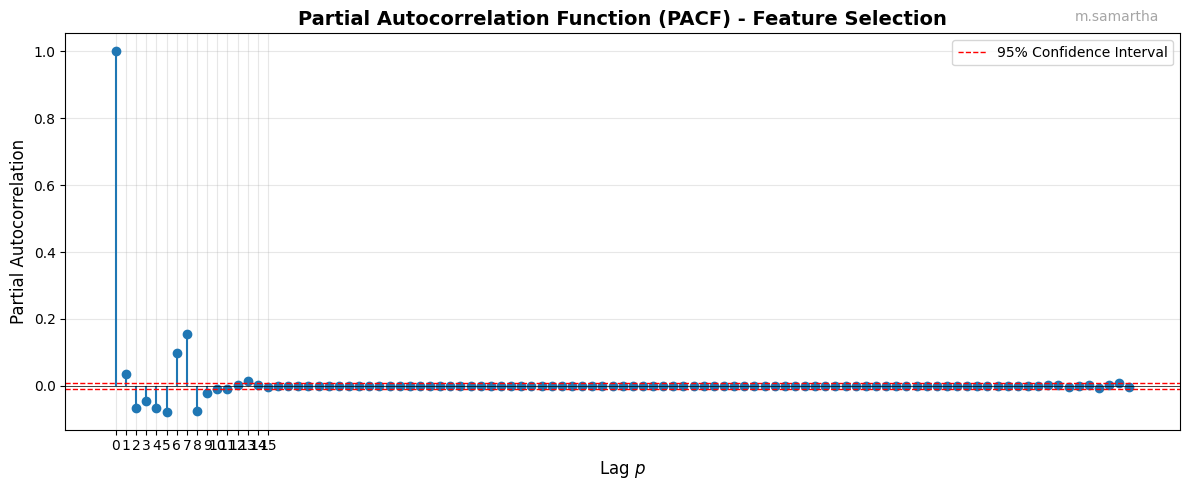


=== PACF Analysis ===
PACF values: [ 1.00000000e+00  3.67217448e-02 -6.72028667e-02 -4.42264534e-02
 -6.71505033e-02 -7.74042001e-02  9.91376663e-02  1.53736960e-01
 -7.56796322e-02 -2.25551937e-02 -8.22917833e-03 -8.69846712e-03
  2.38169972e-03  1.30925382e-02  2.53573218e-03 -3.28211794e-03
 -1.83662077e-03 -1.17443986e-03 -3.95681344e-04  8.66304908e-04
  7.67098782e-04 -2.25422763e-05 -2.59327421e-04 -1.93262167e-04
 -1.15464432e-04  9.05418702e-06  7.19893699e-05  2.39151815e-05
 -3.02125021e-05 -4.16037477e-05 -3.54490133e-05 -2.38054822e-05
 -1.27886811e-05 -1.18007861e-05 -1.73960718e-05 -2.11429904e-05
 -2.16206726e-05 -2.08789696e-05 -1.96224367e-05 -1.83547469e-05
 -1.84059984e-05 -1.94280279e-05 -1.97590998e-05 -1.98344690e-05
 -2.04136085e-05 -1.96381930e-05 -1.79223512e-05 -1.85724531e-05
 -2.00606529e-05 -1.96876446e-05 -2.06617518e-05 -2.19115003e-05
 -1.78497471e-05 -1.48703586e-05 -1.95635729e-05 -2.14437869e-05
 -1.97421733e-05 -2.48402135e-05 -2.36009569e-05 -8.73

In [26]:
file_path = 'Dataset/Q2/recurrence_timeseries.csv' 
df = pd.read_csv(file_path)

# Extract the time series (first column)
data_series = df.iloc[:, 0].values

pacf_vals = pacf(data_series, nlags=100)

# Visualize PACF
plt.figure(figsize=(12, 5))
plt.stem(range(len(pacf_vals)), pacf_vals, basefmt=" ")
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=1.96/np.sqrt(len(data_series)), color='red', linestyle='--', 
            linewidth=1, label='95% Confidence Interval')
plt.axhline(y=-1.96/np.sqrt(len(data_series)), color='red', linestyle='--', linewidth=1)
plt.title("Partial Autocorrelation Function (PACF) - Feature Selection", 
          fontsize=14, fontweight='bold')
plt.xlabel("Lag $p$", fontsize=12)
plt.ylabel("Partial Autocorrelation", fontsize=12)
plt.xticks(range(0, 16))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
add_username_fig(fig=plt.gcf())
plt.show()

# Analysis
print("\n=== PACF Analysis ===")
print(f"PACF values: {pacf_vals}")

#### PACF Analysis
Based on the PACF plot below, we observe significant correlations up to lag 7-8. Thus, we select p=7 to capture sufficient history without overfitting.

## 2.3 Analytical Recurrence Identification 

In [27]:
P_BEST = 7

def create_raw_supervised_pairs(raw_data: np.ndarray, p: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Creates (history, target) pairs from the raw time series data.
    """
    X, y = [], []
    for i in range(len(raw_data) - p):
        history = raw_data[i : (i + p)]
        target = raw_data[i + p]
        X.append(history)
        y.append(target)
    
    # Create feature names for later: ['x_k-p', ..., 'x_k-1']
    feature_names = [f'x_k-{p-i}' for i in range(p)]
    
    return np.array(X), np.array(y), feature_names

# Create raw pairs for train, val, and test sets
X_train_raw, y_train_raw, feature_names = create_raw_supervised_pairs(processor.train_raw, P_BEST)
X_val_raw, y_val_raw, _ = create_raw_supervised_pairs(processor.val_raw, P_BEST)
X_test_raw, y_test_raw, _ = create_raw_supervised_pairs(processor.test_raw, P_BEST)

print(f"Created raw data pairs with p={P_BEST}")
print(f"X_train_raw shape: {X_train_raw.shape}, y_train_raw shape: {y_train_raw.shape}")
print(f"X_test_raw shape: {X_test_raw.shape}, y_test_raw shape: {y_test_raw.shape}")
print(f"Feature names: {feature_names}")

# Store all test MSEs here for final comparison
model_comparison = {}

Created raw data pairs with p=7
X_train_raw shape: (37793, 7), y_train_raw shape: (37793,)
X_test_raw shape: (8093, 7), y_test_raw shape: (8093,)
Feature names: ['x_k-7', 'x_k-6', 'x_k-5', 'x_k-4', 'x_k-3', 'x_k-2', 'x_k-1']



--- Method 1: Linear Recurrence ---
Discovered Linear Formula:
x_k = -0.000617 + (0.154049 * x_k-7) + (0.096172 * x_k-6) + (-0.073325 * x_k-5) + (-0.058157 * x_k-4) + (-0.037917 * x_k-3) + (-0.051944 * x_k-2) + (0.021625 * x_k-1) 


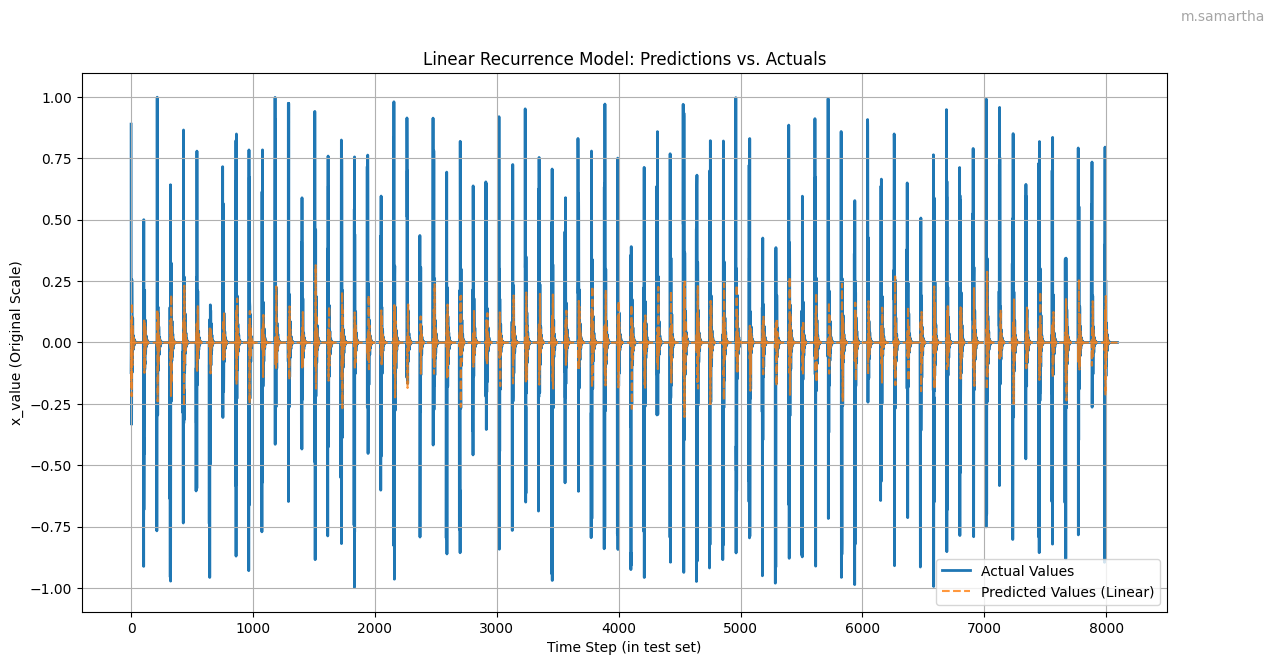


Test MSE (Linear): 0.023690
Train MSE (Linear): 0.024574



In [34]:
print("\n--- Method 1: Linear Recurrence ---")

# 1. Create and fit the model
linear_model = LinearRegression()
linear_model.fit(X_train_raw, y_train_raw)

# 2. Get the analytical formula
intercept = linear_model.intercept_
coeffs = linear_model.coef_

formula = f"x_k = {intercept:.6f} "
for name, coeff in zip(feature_names, coeffs):
    formula += f"+ ({coeff:.6f} * {name}) "

print("Discovered Linear Formula:")
print(formula)

# 3. Evaluate and store residuals
y_pred_linear = linear_model.predict(X_test_raw)
mse_linear = mean_squared_error(y_test_raw, y_pred_linear)
model_comparison['Linear'] = mse_linear
mse_linear_train = mean_squared_error(y_train_raw, linear_model.predict(X_train_raw))

# Plot predictions vs actuals for linear model
plt.figure(figsize=(14, 7))
plt.plot(y_test_raw, label='Actual Values', linewidth=2, zorder=1)
plt.plot(y_pred_linear, label='Predicted Values (Linear)', linestyle='--', alpha=0.8, zorder=2)
plt.title('Linear Recurrence Model: Predictions vs. Actuals')
plt.xlabel('Time Step (in test set)')
plt.ylabel('x_value (Original Scale)')
plt.legend()
plt.grid(True)
add_username_fig(fig=plt.gcf())
plt.show()  

print(f"\nTest MSE (Linear): {mse_linear:.6f}")
print(f"Train MSE (Linear): {mse_linear_train:.6f}\n")


--- Method 2: Polynomial Recurrence ---
Discovered Polynomial Formula (Degree 2):
x_k = 0.000431 + (0.153529 * x_k-7) + (0.095691 * x_k-6) + (-0.072961 * x_k-5) + (-0.059931 * x_k-4) + (-0.038666 * x_k-3) + (-0.050171 * x_k-2) + (0.022312 * x_k-1) + (0.005734 * x_k-7^2) + (0.003311 * x_k-7 x_k-6) + (-0.022866 * x_k-7 x_k-5) + (0.028424 * x_k-7 x_k-4) + (0.017323 * x_k-7 x_k-3) + (-0.013550 * x_k-7 x_k-2) + (0.048839 * x_k-7 x_k-1) + (0.002062 * x_k-6^2) + (0.015938 * x_k-6 x_k-5) + (0.007057 * x_k-6 x_k-4) + (0.004277 * x_k-6 x_k-3) + (0.037691 * x_k-6 x_k-2) + (-0.016860 * x_k-6 x_k-1) + (-0.036777 * x_k-5^2) + (-0.035595 * x_k-5 x_k-4) + (0.020131 * x_k-5 x_k-3) + (0.020827 * x_k-5 x_k-2) + (0.037535 * x_k-5 x_k-1) + (0.012644 * x_k-4^2) + (-0.047744 * x_k-4 x_k-3) + (-0.019189 * x_k-4 x_k-2) + (0.001177 * x_k-4 x_k-1) + (0.037959 * x_k-3^2) + (0.041878 * x_k-3 x_k-2) + (0.024396 * x_k-3 x_k-1) + (-0.027295 * x_k-2^2) + (0.010398 * x_k-2 x_k-1) + (-0.031052 * x_k-1^2) 


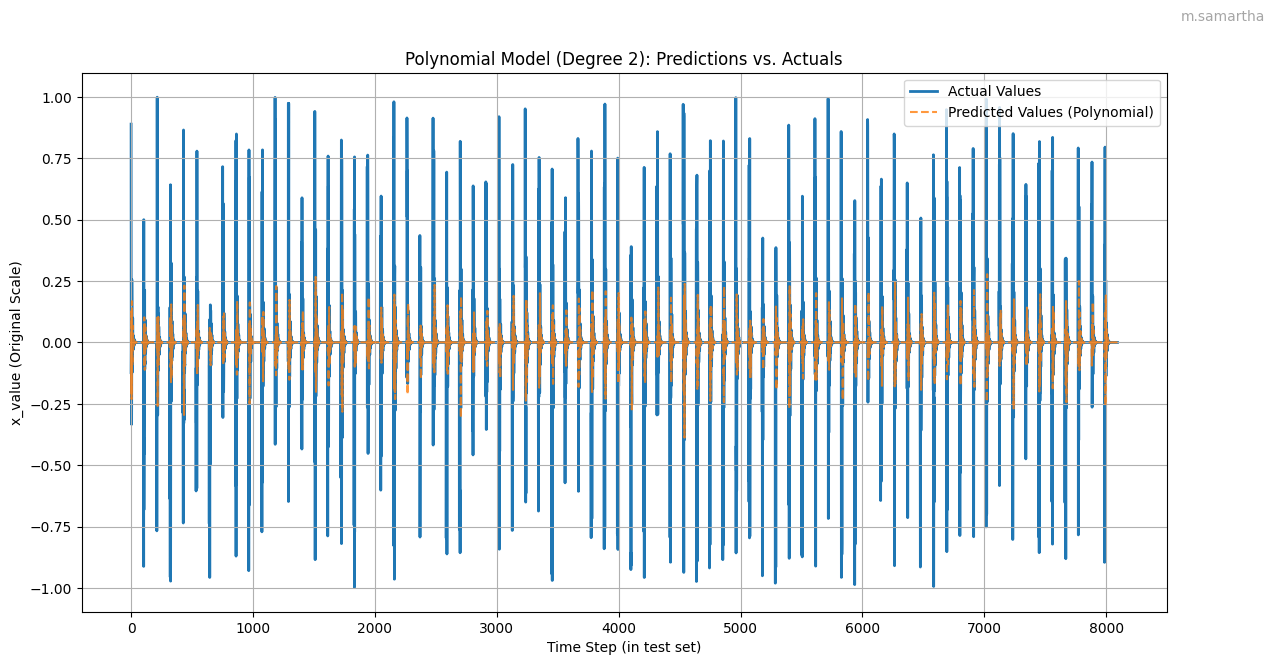


Test MSE (Polynomial): 0.023911
Train MSE (Polynomial): 0.024449



In [35]:
print("\n--- Method 2: Polynomial Recurrence ---")

# We'll use a degree=2 polynomial to start.
# This finds interactions (x_i * x_j) and powers (x_i^2).
poly = PolynomialFeatures(degree=2, include_bias=False)
lin_reg = LinearRegression()

# Create a pipeline to first transform features, then fit
poly_pipeline = Pipeline([
    ('poly_features', poly),
    ('linear_regression', lin_reg)
])

# 1. Fit the model
poly_pipeline.fit(X_train_raw, y_train_raw)

# 2. Get the analytical formula (this one is more complex!)
poly_feature_names = poly.get_feature_names_out(input_features=feature_names)
final_coeffs = poly_pipeline.named_steps['linear_regression'].coef_
final_intercept = poly_pipeline.named_steps['linear_regression'].intercept_

poly_formula = f"x_k = {final_intercept:.6f} "
for name, coeff in zip(poly_feature_names, final_coeffs):
    if abs(coeff) > 1e-4: # Only print non-trivial terms
        poly_formula += f"+ ({coeff:.6f} * {name}) "

print("Discovered Polynomial Formula (Degree 2):")
print(poly_formula)

# 3. Evaluate and store residuals
y_pred_poly = poly_pipeline.predict(X_test_raw)
mse_poly = mean_squared_error(y_test_raw, y_pred_poly)
model_comparison['Polynomial (D=2)'] = mse_poly
mse_poly_train = mean_squared_error(y_train_raw, poly_pipeline.predict(X_train_raw))

# Plot predictions vs actuals for polynomial model
plt.figure(figsize=(14, 7))
plt.plot(y_test_raw, label='Actual Values', linewidth=2, zorder=1)
plt.plot(y_pred_poly, label='Predicted Values (Polynomial)', linestyle='--', alpha=0.8, zorder=2)
plt.title('Polynomial Model (Degree 2): Predictions vs. Actuals')
plt.xlabel('Time Step (in test set)')
plt.ylabel('x_value (Original Scale)')
plt.legend()
plt.grid(True)
add_username_fig(fig=plt.gcf())
plt.show()

print(f"\nTest MSE (Polynomial): {mse_poly:.6f}")
print(f"Train MSE (Polynomial): {mse_poly_train:.6f}\n")

### Compare RNN with Linear and Polynomial Regression Models

| Model Type               | Train MSE | Test MSE | Learned Recurrence Relation            |
|--------------------------|----------|----------|----------------------------------------|
| RNN (p=7)                |  0.024   | 0.023561 |    NA                                   |
|  Linear                  |  0.024574   | 0.023690 |  $x_k = -0.000617 + ... + (-0.037917 * x_k-3) + (-0.051944 * x_k-2) + (0.021625 * x_k-1)$   |
| Polynomial (degree=2) |  0.024449   | 0.023911 |  $x_k = 0.000431 + (0.153529 * x_k-7) + (0.095691 * x_k-6) + (-0.072961 * x_k-5) + ...$   |


Thus, from the above table, we observe that the RNN model outperforms both linear and polynomial regression models in terms of test MSE. The RNN's ability to capture complex temporal dependencies allows it to learn a more accurate recurrence relation compared to the simpler linear and polynomial models. However, the difference between the Test MSE values is relatively small, this is because of the nature of the problem.

## 2.4 Evaluation Criterion

### Single-step prediction with RNN (DL model)

In [ ]:
best_model.model.eval()

# --- 1. Get Single-Step Predictions from DL Model ---
with torch.no_grad():
    y_pred_norm_t = best_model.model(X_test_t)

# Move to CPU and flatten
y_pred_norm = y_pred_norm_t.cpu().numpy().flatten()
y_actual_norm = y_test_t.cpu().numpy().flatten()

# --- 2. Inverse-Transform to Original Scale ---
# We must evaluate on the original scale
y_pred_orig = processor.inverse_transform_predictions(y_pred_norm)
y_actual_orig = processor.inverse_transform_predictions(y_actual_norm)

# --- 3. Calculate Metrics ---
mse_dl_single_step = mean_squared_error(y_actual_orig, y_pred_orig)
mae_dl_single_step = mean_absolute_error(y_actual_orig, y_pred_orig)

print("--- 2.4.1: Single-Step DL Model Evaluation ---")
print(f"Test Set MSE (Single-Step): {mse_dl_single_step:.6f}")
print(f"Test Set MAE (Single-Step): {mae_dl_single_step:.6f}")

--- 2.4.1: Single-Step DL Model Evaluation ---
Test Set MSE (Single-Step): 0.023645
Test Set MAE (Single-Step): 0.046078


### Autoregressive Generation (Long-Range Forecast)

In [51]:
def generate_autoregressive_analytical(model, initial_history, steps):
    """
    Generates an autoregressive sequence using a scikit-learn model.
    
    Args:
        model: Your fitted poly_pipeline.
        initial_history: A numpy array of shape (p,).
        steps: How many steps to predict.
    
    Returns:
        A numpy array of length (steps,) with the predictions.
    """
    generated_sequence = []
    current_history = initial_history.copy()
    
    for _ in range(steps):
        # Predict the next step
        pred = model.predict(current_history.reshape(1, -1))[0]
        generated_sequence.append(pred)
        
        # Roll the history window: drop the oldest, add the prediction
        current_history = np.roll(current_history, -1)
        current_history[-1] = pred
        
    return np.array(generated_sequence)

def generate_autoregressive_dl(model, processor, initial_norm_history, steps, device):
    """
    Generates an autoregressive sequence using a PyTorch RNN model.
    Operates *entirely in the normalized space* until the end.
    
    Args:
        model: Your fitted PyTorch RNN.
        processor: The data processor (for un-scaling).
        initial_norm_history: A numpy array shape (p, 1).
        steps: How many steps to predict.
    
    Returns:
        A numpy array of length (steps,) with predictions in the *original scale*.
    """
    model.eval()
    generated_norm_sequence = []
    current_history = initial_norm_history.copy() # Shape (p, 1)
    
    with torch.no_grad():
        for _ in range(steps):
            # 1. Reshape and convert history for the model
            history_tensor = torch.tensor(current_history).float().to(device)
            history_tensor = history_tensor.reshape(1, P_BEST, 1) # (batch, seq, features)
            
            # 2. Predict the next step
            pred_norm = model(history_tensor).item() # Get single float value
            generated_norm_sequence.append(pred_norm)
            
            # 3. Roll the history window (in normalized space)
            current_history = np.roll(current_history, -1, axis=0)
            current_history[-1, 0] = pred_norm
            
    # 4. Inverse-transform the *entire* generated sequence
    generated_orig = processor.inverse_transform_predictions(
        np.array(generated_norm_sequence)
    )
    return generated_orig

In [52]:
FILE_PATH = 'Dataset/Q2/recurrence_timeseries.csv' 
HISTORY_LENGTH_P = 7

print(f"Using history length p = {HISTORY_LENGTH_P}")
processor = TimeSeriesDataProcessor(filepath=FILE_PATH, 
                                  p=HISTORY_LENGTH_P, 
                                  train_ratio=0.7, 
                                  val_ratio=0.15)
X_train, y_train, X_val, y_val, X_test, y_test = processor.get_processed_data()

# --- 2. Convert data to PyTorch Tensors ---
X_train_t = torch.tensor(X_train).float().to(device)
y_train_t = torch.tensor(y_train).float().view(-1, 1).to(device) # view(-1, 1) for (N, 1) shape

X_val_t = torch.tensor(X_val).float().to(device)
y_val_t = torch.tensor(y_val).float().view(-1, 1).to(device)

X_test_t = torch.tensor(X_test).float().to(device)
y_test_t = torch.tensor(y_test).float().view(-1, 1).to(device)

# --- 3. Create DataLoaders for batching ---
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with batch size {BATCH_SIZE}")

Using history length p = 7
DataLoaders created with batch size 32



--- 2.4.3: Autoregressive Error vs. Forecast Length ---
Evaluating Analytical (Linear) Model...
Evaluating DL (RNN) Model...


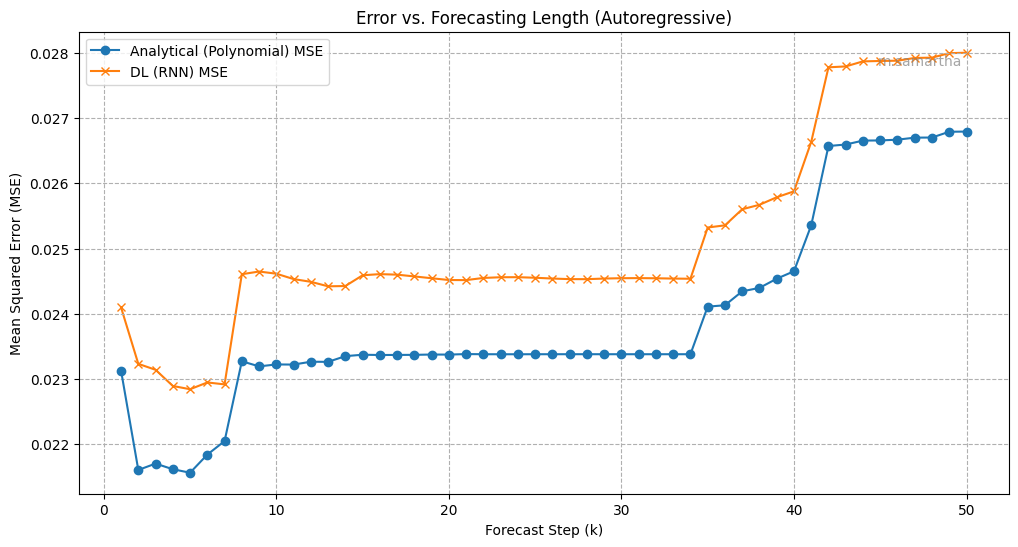

In [ ]:
def evaluate_forecast_error(model, X_test, y_test, max_forecast, num_starts, 
                              model_type='sklearn', processor=None, device=None):
    """
    Calculates the MSE for each step in a forecast.
    
    Args:
        model: The model to test (sklearn or pytorch).
        X_test: Test set features (raw or normalized).
        y_test: Test set targets (raw or normalized).
        max_forecast: The max number of steps to forecast (e.g., 50).
        num_starts: How many different starting points to average over.
        model_type: 'sklearn' or 'dl'.
        processor: Required if model_type=='dl'.
        device: Required if model_type=='dl'.
    
    Returns:
        A numpy array of MSE values, one for each forecast step.
    """
    # Ensure we don't go out of bounds
    num_starts = min(num_starts, len(X_test) - max_forecast)
    all_squared_errors = [] # List to hold error arrays

    for i in range(num_starts):
        # 1. Get the starting history
        initial_history = X_test[i]
        
        # 2. Get the *actual* future values
        actual_future = y_test[i : i + max_forecast]
        
        # 3. Generate the predicted future
        if model_type == 'sklearn':
            # initial_history is (p,)
            predicted_future = generate_autoregressive_analytical(
                model, initial_history, max_forecast
            )
            # actual_future is already raw
            
        elif model_type == 'dl':
            # initial_history is (p, 1)
            predicted_future = generate_autoregressive_dl(
                model, processor, initial_history, max_forecast, device
            )
            # Need to un-scale the actuals for comparison
            actual_future = processor.inverse_transform_predictions(actual_future)
        
        # 4. Calculate squared error for this rollout
        squared_errors = (predicted_future - actual_future)**2
        all_squared_errors.append(squared_errors)
        
    # 5. Average the errors across all starting points
    # Shape of all_squared_errors is (num_starts, max_forecast)
    mse_per_step = np.mean(all_squared_errors, axis=0)
    return mse_per_step

# --- Run the Evaluation ---
FORECAST_STEPS = 50
NUM_STARTS = 500 # Average over 500 different starting points

print("\n--- 2.4.3: Autoregressive Error vs. Forecast Length ---")
print("Evaluating Analytical (Linear) Model...")

mse_analytical = evaluate_forecast_error(
    linear_model, 
    X_test_raw, 
    y_test_raw, 
    FORECAST_STEPS, 
    NUM_STARTS, 
    model_type='sklearn'
)

print("Evaluating DL (RNN) Model...")

y_test_targets_norm = y_test_t.cpu().numpy().flatten()

mse_dl = evaluate_forecast_error(
    best_model.model, 
    X_test_t.cpu().numpy(), # X_test_t is (N, p, 1)
    y_test_targets_norm,
    FORECAST_STEPS, 
    NUM_STARTS, 
    model_type='dl', 
    processor=processor, 
    device=device
)

# --- Plot the Results ---
plt.figure(figsize=(12, 6))
plt.plot(range(1, FORECAST_STEPS + 1), mse_analytical, 
         label='Analytical (Linear) MSE', marker='o', zorder=2)
plt.plot(range(1, FORECAST_STEPS + 1), mse_dl, 
         label='DL (RNN) MSE', marker='x', zorder=1)
plt.title('Error vs. Forecasting Length (Autoregressive)')
plt.xlabel('Forecast Step (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True, linestyle='--')
add_username()
plt.show()

### Conclusion for autoregressive generation
In the autoregressive generation task, the RNN model's performance degrades significantly over long horizons. The MSE increases as the number of forecasted steps grows, indicating that errors accumulate and compound over time. This is a common challenge in autoregressive models, where each prediction depends on previous predictions, leading to drift from the true trajectory. Counter-intuitively, the linear model performs better than the RNN, due to its simplicity and the difficulty of training RNNs, which has been explained in detail in the end of section 2.2.

## 2.5 Parsimony and Stability 

   num_params  final_train_loss  final_val_loss
0        1121          0.026497        0.027475
1        3201          0.026395        0.026389
2        4289          0.027303        0.032994
3        5281          0.026501        0.027019
4       12545          0.027381        0.032570
5       16769          0.029326        0.031004
6       20801          0.027343        0.027878
7       49665          0.029621        0.030102
8       82561          0.030293        0.035056


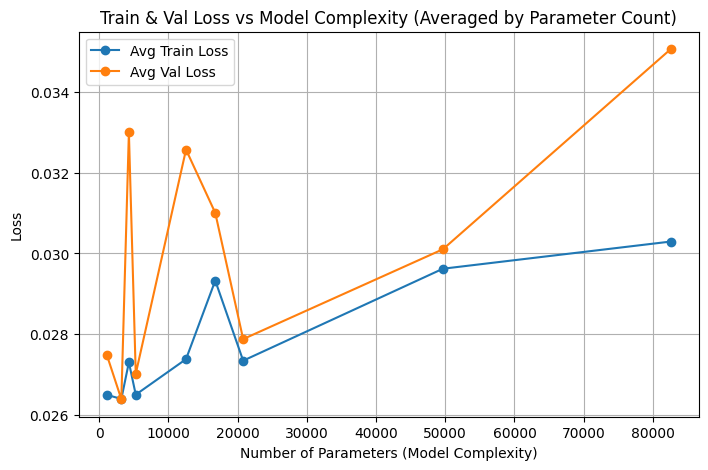

In [61]:
# ---- Function to compute number of parameters in a vanilla RNN ----
def count_rnn_params(input_size, hidden_size, output_size, num_layers):
    total_params = 0

    # Layer 1
    total_params += input_size * hidden_size     # W_xh
    total_params += hidden_size * hidden_size    # W_hh
    total_params += hidden_size                  # b_h

    # Layers 2+
    for _ in range(num_layers - 1):
        total_params += hidden_size * hidden_size   # W_xh
        total_params += hidden_size * hidden_size   # W_hh
        total_params += hidden_size                 # b_h

    # Output layer
    total_params += hidden_size * output_size     # W_out
    total_params += output_size                   # b_out

    return total_params


# -------------------------------
# Build summary dataframe
# -------------------------------
summary = []

for r in all_results:
    params = r["params"]
    df = r["results_df"]

    n_params = count_rnn_params(
        input_size=params["input_size"],
        hidden_size=params["hidden_size"],
        output_size=params["output_size"],
        num_layers=params["num_layers"]
    )

    summary.append({
        "num_params": n_params,
        "final_train_loss": df["train_loss"].iloc[-1],
        "final_val_loss": df["val_loss"].iloc[-1],
    })

summary_df = pd.DataFrame(summary)

# -------------------------------
# Group by parameter count & average
# -------------------------------
grouped = summary_df.groupby("num_params").mean().reset_index()

print(grouped)

# -------------------------------
# Line plot (averaged losses)
# -------------------------------
plt.figure(figsize=(8,5))

plt.plot(grouped["num_params"], grouped["final_train_loss"],
         marker="o", label="Avg Train Loss")

plt.plot(grouped["num_params"], grouped["final_val_loss"],
         marker="o", label="Avg Val Loss")

plt.xlabel("Number of Parameters (Model Complexity)")
plt.ylabel("Loss")
plt.title("Train & Val Loss vs Model Complexity (Averaged by Parameter Count)")
plt.legend()
plt.grid(True)
plt.show()

### Conclusion for Parsimony and Stability
The analysis of model parsimony and stability reveals that simpler models with fewer parameters tend to exhibit greater stability in their predictions. Models with excessive complexity are prone to overfitting/underfitting, leading to erratic behavior when exposed to new data. Again, owing to the `curse of dimensionality`, simpler models generalize better with the given small dataset. The loss would have decreased with increasing complexity had the data been much more larger than the parameter count. Extensive reasons for this phenomenon have been provided in section 2.2. 